## TOC:
* [Model Choice](#first)
* [Feature Engineering](#second)
* [Hyperparameters](#third)

In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [21]:
import pmdarima as pm
import xgboost as xgb
import tsfresh
import sklearn
import shap

In [ ]:
from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [12]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

In [4]:
sns.set_style('whitegrid')
plt.rcParams["figure.figsize"] = (12,6)

Let's load a prepared data

In [4]:
data_train = pd.read_excel('data/data_tmp4.xlsx',index_col=0)
data_train_test = pd.read_excel('data/data_train_test.xlsx',index_col=0)

In [5]:
target = ['INCOME STATEMENT///Operating Income', 'INCOME STATEMENT///Revenue']

In [6]:
data_train_dates = sorted(data_train['date'].unique())
data_train_test_dates = sorted(data_train_test['date'].unique())

In [7]:
test_dates = [x for x in data_train_test_dates if x not in data_train_dates]

In [8]:
data_test = data_train_test[data_train_test['date'].isin(test_dates)]

In [9]:
data_test

date company  INCOME STATEMENT///Revenue  \
18   2020-09-30    CDEV                  114.615000   
19   2020-12-31    CDEV                  142.859008   
20   2021-03-31    CDEV                  169.504992   
21   2021-06-30    CDEV                  195.064000   
60   2020-09-30     COG                  291.040992   
...         ...     ...                         ...   
1939 2021-06-30     CPE                  440.399008   
1978 2020-09-30     MCF                   31.348000   
1979 2020-12-31     MCF                   29.157000   
1980 2021-03-31     MCF                   59.950000   
1981 2021-06-30     MCF                   83.640000   

      INCOME STATEMENT///% Surprise | % Est. vs Consensus  \
18                                            -0.018060     
19                                             0.001711     
20                                             0.073863     
21                                            -0.007727     
60                                            -0.173649     
...                                                 ...     
1939                                           0.306268     
1978                                           0.000000     
1979                                           0.000000     
1980                                          -0.054416     
1981                                           0.213933     

      INCOME STATEMENT///Revenue Growth (YoY)  \
18                                  -0.481173   
19                                  -0.435215   
20                                  -0.120442   
21                                   1.332883   
60                                  -0.321758   
...                                       ...   
1939                                 1.800915   
1978                                 1.498446   
1979                                -0.216062   
1980                                 0.734012   
1981                                 3.687815   

      INCOME STATEMENT///Gross margin  \
18                          -0.229822   
19                           0.101506   
20                           0.275231   
21                           0.324924   
60                           0.070773   
...                               ...   
1939                         0.544061   
1978                         0.255455   
1979                         0.212127   
1980                         0.389141   
1981                         0.426518   

      INCOME STATEMENT///Other Operating Expenses  \
18                                         -2.088   
19                                         -7.625   
20                                         11.488   
21                                         14.004   
60                                         -3.900   
...                                           ...   
1939                                      -22.468   
1978                                        0.643   
1979                                        0.613   
1980                                        1.650   
1981                                        0.313   

      INCOME STATEMENT///Operating Income  \
18                             -46.011000   
19                             -11.545000   
20                              32.885000   
21                              48.578000   
60                              -7.564000   
...                                   ...   
1939                           206.071008   
1978                             2.521000   
1979                            -0.874000   
1980                            13.620000   
1981                            22.504000   

      INCOME STATEMENT///Operating Margin  \
18                              -0.401440   
19                              -0.080814   
20                               0.194006   
21                               0.249036   
60                              -0.025989   
...                                   ...   
1939                             0.467919 

# <a name="first"></a> Model choice 

## Classical Time Series analysis

Let's start with prediction using time series econometric models. I'm going to use SMAPE metric for model evaluations, which is defined as follows:

$$
SMAPE = \frac{100\%}{n}\sum\limits_{i=1}^n\frac{2||y_i - \hat{y}_i||}{||y_i||+||\hat{y}_i||}
$$

It'll allow us to scale 2-d predictions (income & revenue) of different level (smaller and bigger companies) to the similar percentage rate.

In [15]:
def smape(y_true, y_pred, order=2):
    if not isinstance(y_true, np.ndarray):
        y_true = np.asarray(y_true)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.asarray(y_pred)
    return 100*np.mean(2*np.linalg.norm(y_true-y_pred, ord=order))/(np.linalg.norm(y_true, ord=order)+np.linalg.norm(y_pred, ord=order))

Let us start with ARIMAX model. It incorporates:

* Autoregressive (AR) part

* Intergration (I) part

* Moving average (MA) part

* Exogenous variable (X) part

I've decided to follow instructions from the [link](https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6).

As the model deals only with 1-d endogenous variable, we predict our target values separately. For simplicity, now we use only company name as exogenous variable.

In [12]:
data_train['company'].values.reshape(-1, 1)

array([['AMPY'],
       ['AMPY'],
       ['AMPY'],
       ...,
       ['XOG'],
       ['XOG'],
       ['XOG']], dtype=object)

In [13]:
enc = OneHotEncoder(drop='first')
enc.fit(data_train['company'].values.reshape(-1, 1))
dummies_train = enc.transform(data_train['company'].values.reshape(-1, 1)).toarray()
dummies_test = enc.transform(data_test['company'].values.reshape(-1, 1)).toarray()

In [14]:
SARIMAX_model = pm.auto_arima(y=data_train[target[0]],
                             X=dummies_train,
                             xstart_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, 
                             #m=12, #12 is the frequncy of the cycle
                             start_P=0, 
                             seasonal=True, #set to seasonal
                             d=None, 
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

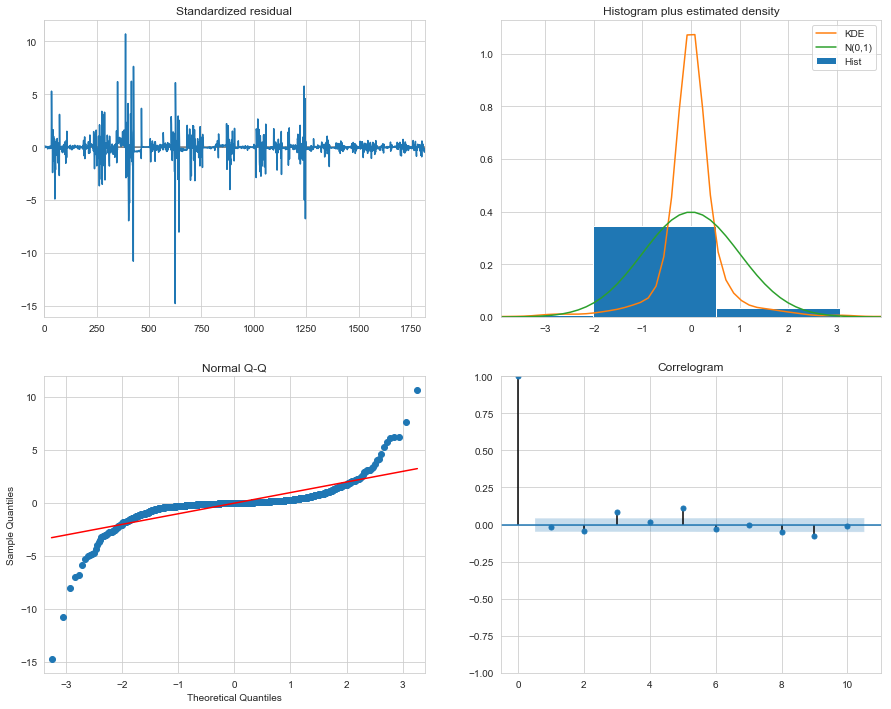

In [15]:
SARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [16]:
SARIMAX_model1 = pm.auto_arima(y=data_train[target[1]],
                             X=dummies_train,
                             xstart_p=1, start_q=1,
                             test='adf',
                             max_p=3, max_q=3, 
                             #m=12, #12 is the frequncy of the cycle
                             start_P=0, 
                             seasonal=True, #set to seasonal
                             d=None, 
                             D=1, #order of the seasonal differencing
                             trace=False,
                             error_action='ignore',  
                             suppress_warnings=True, 
                             stepwise=True)

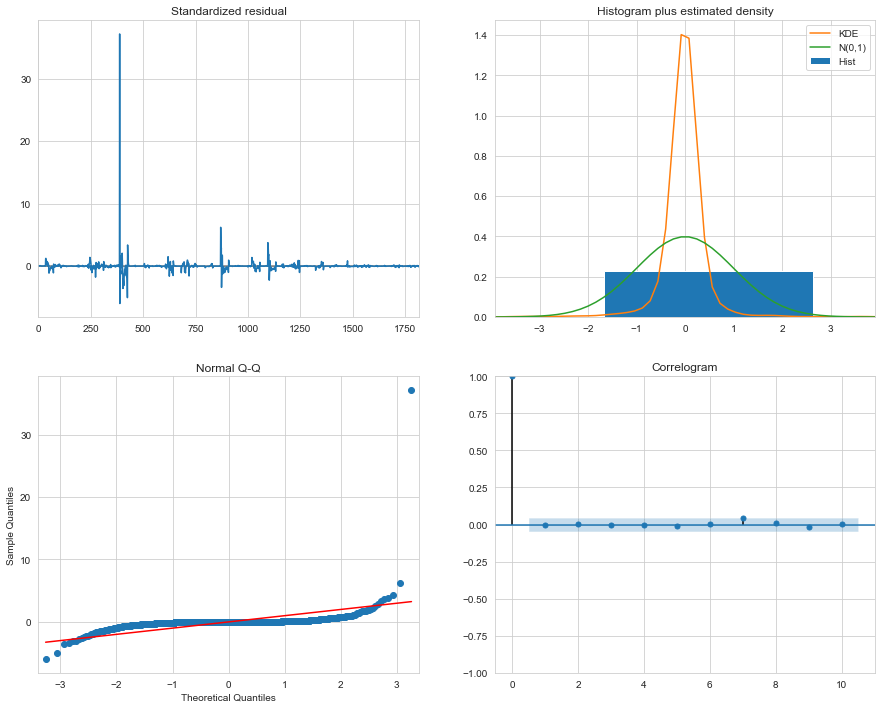

In [17]:
SARIMAX_model1.plot_diagnostics(figsize=(15,12))
plt.show()

I think the main problem here is that we consider our sample as univariate. That's why it might be better to switch to multivariate models.

### VARMA model

In [19]:
var_train = data_train[['date', 'company']+target].copy()

In [20]:
var_train = var_train.set_index(['company','date']).unstack(0)

In [21]:
var_train = var_train.reorder_levels(order=[1,0], axis=1)

We fill NA values with backfill in order fit model:

In [22]:
model = VAR(var_train.fillna(method='bfill'), dates=var_train.index)
results = model.fit()

No frequency information was provided, so inferred frequency Q-DEC will be used.


In [23]:
lag_order = results.k_ar
forecasts = results.forecast(var_train.values[-lag_order:], 4)

In [24]:
var_test = data_test[['date', 'company']+target].copy()
var_test = var_test.set_index(['company','date']).unstack(0)
var_test = var_test.reorder_levels(order=[1,0], axis=1)

For some reason one company from the train data is not presented in the test data.

In [25]:
forecasts = forecasts[:,var_train.columns.isin(var_test.columns)]

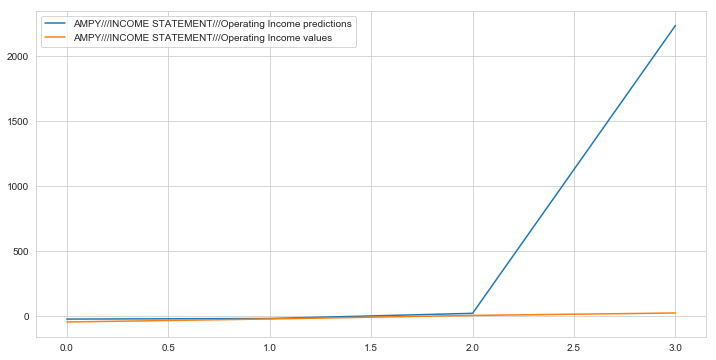

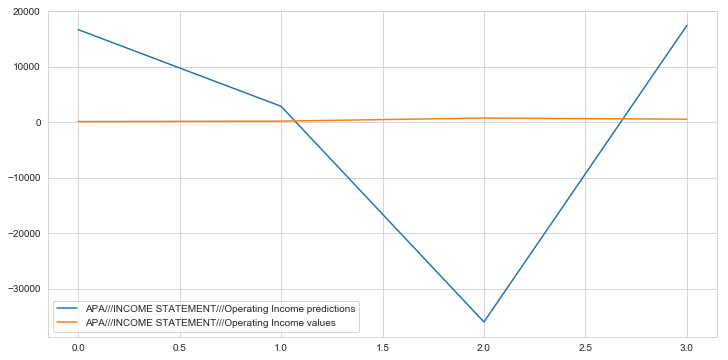

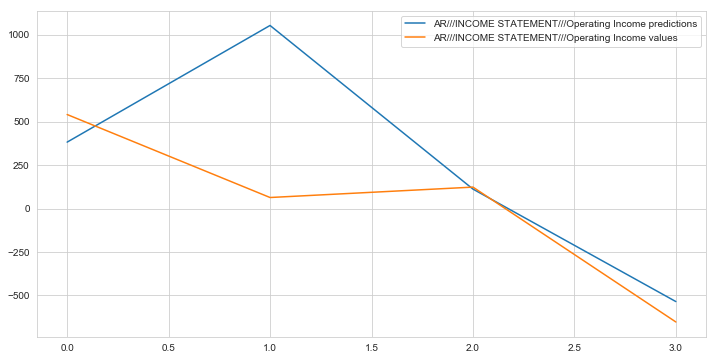

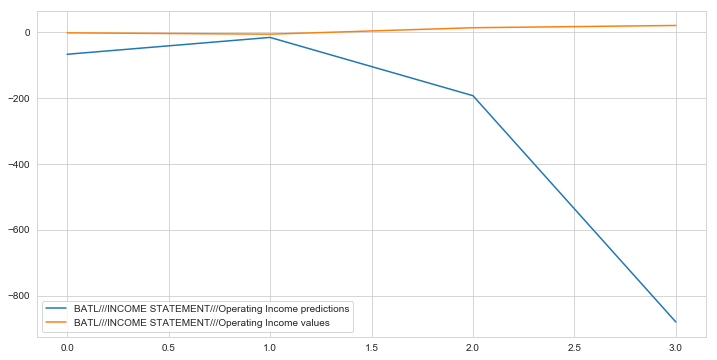

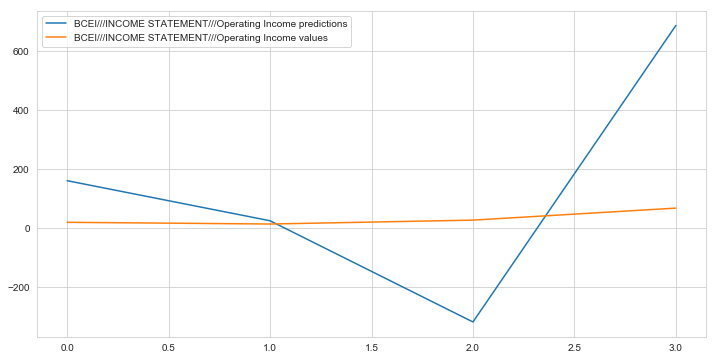

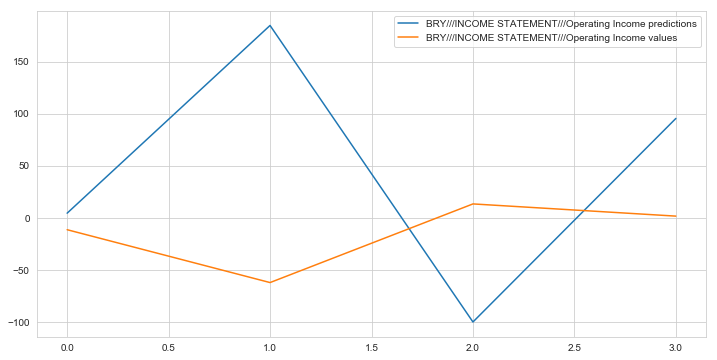

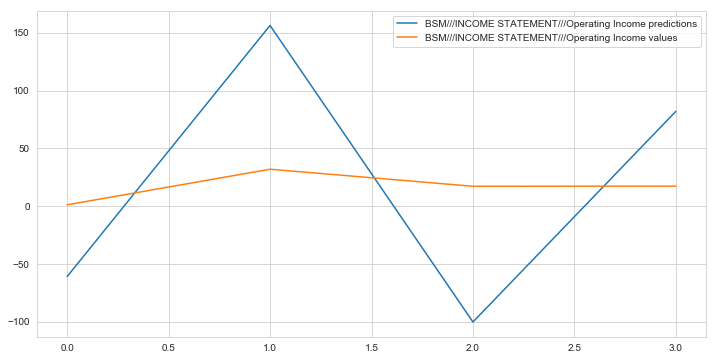

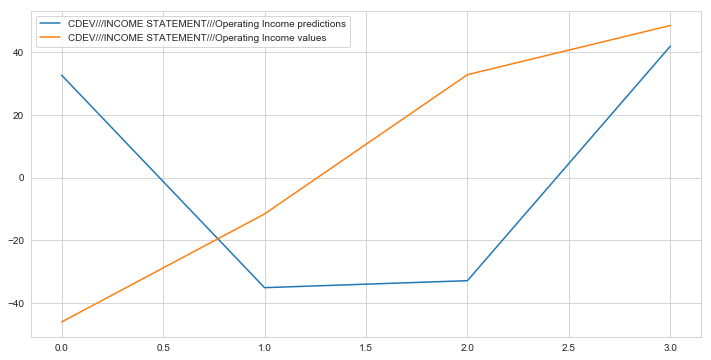

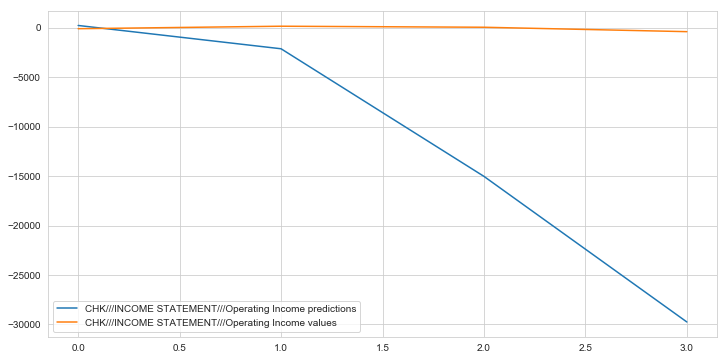

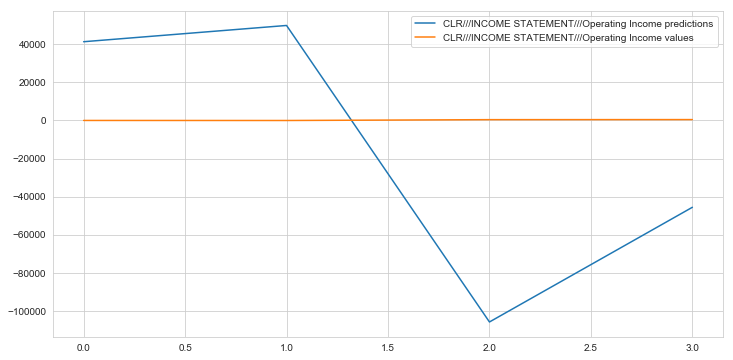

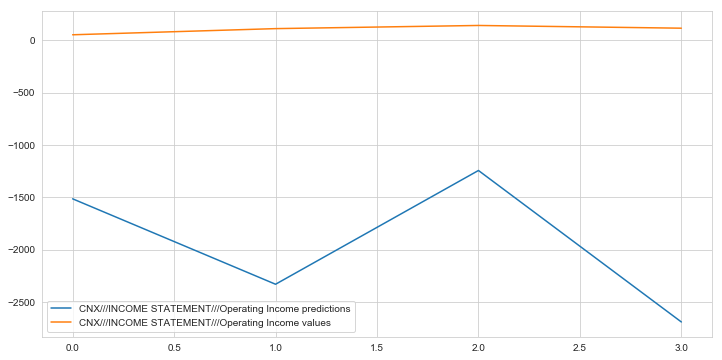

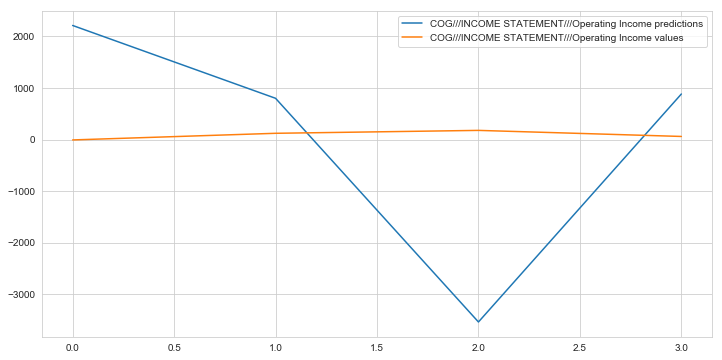

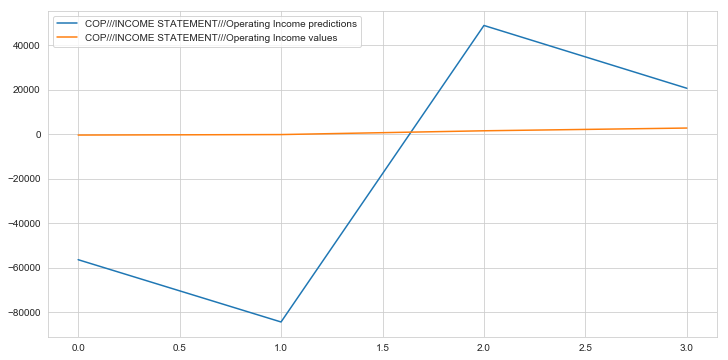

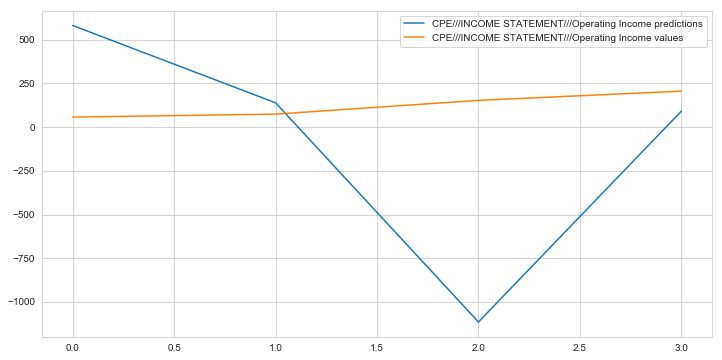

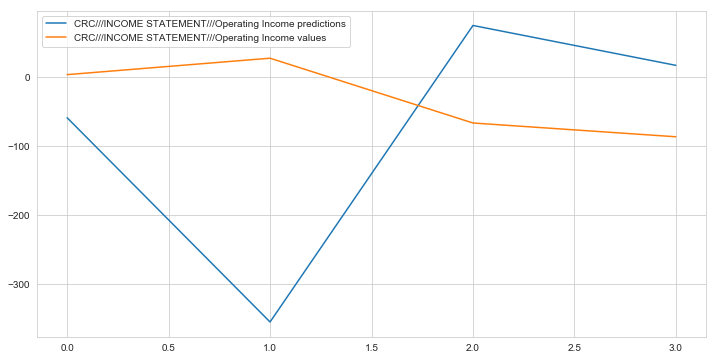

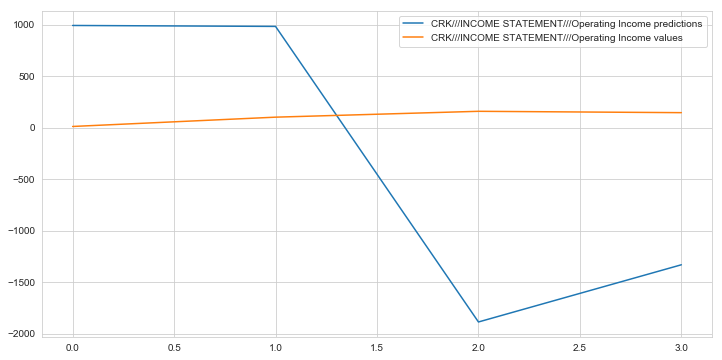

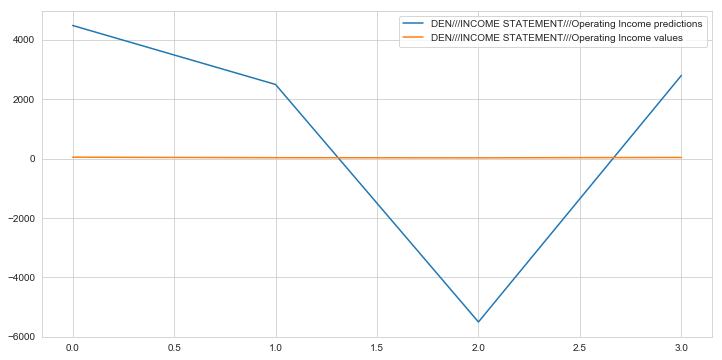

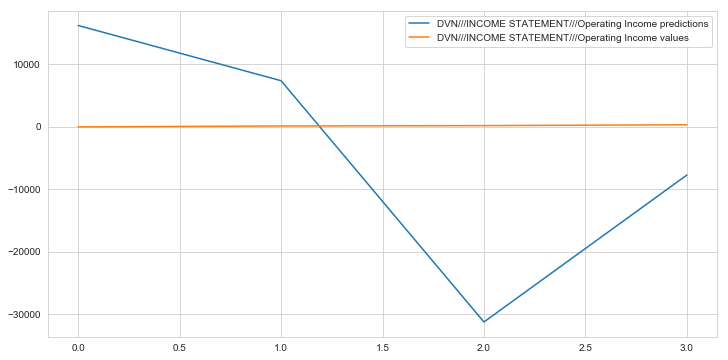

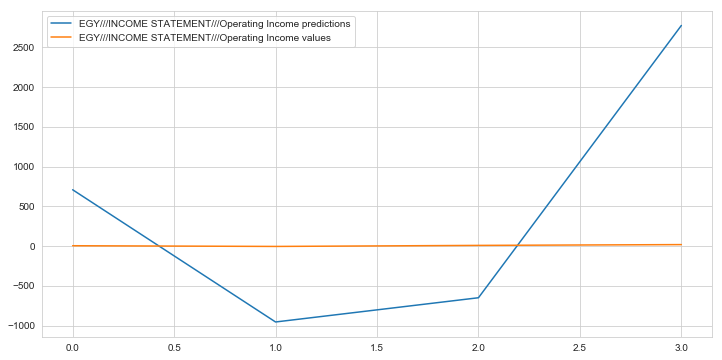

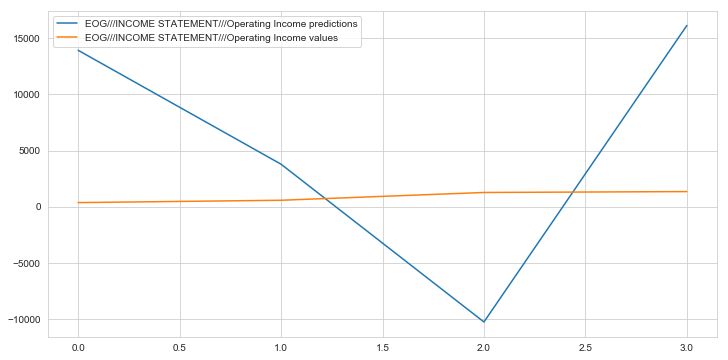

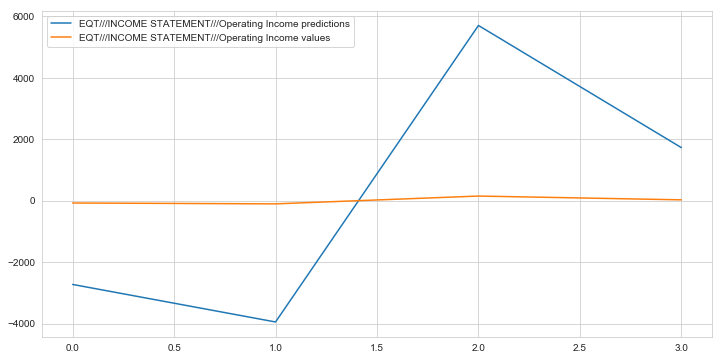

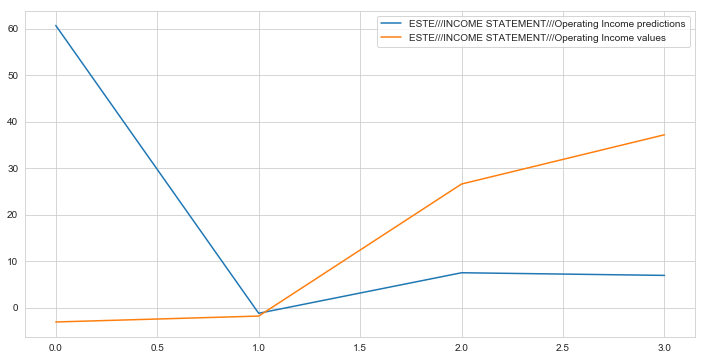

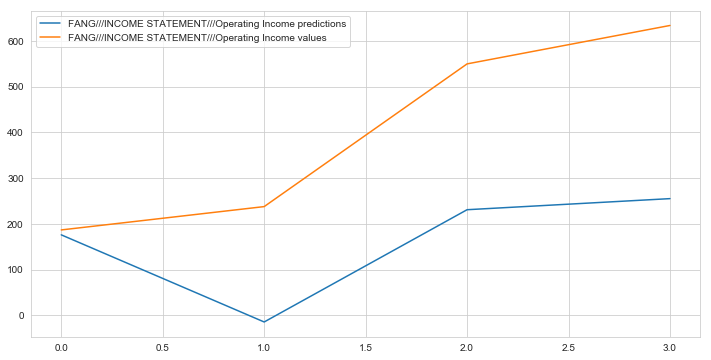

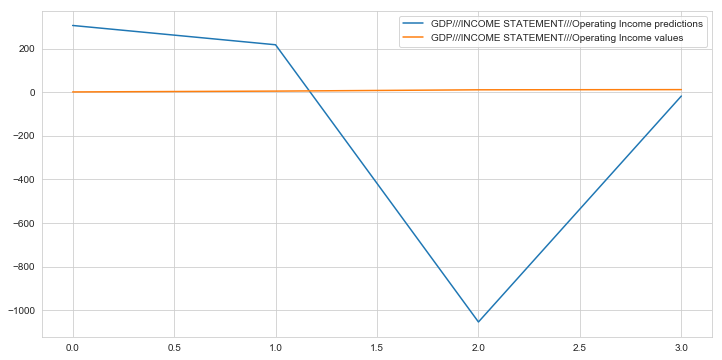

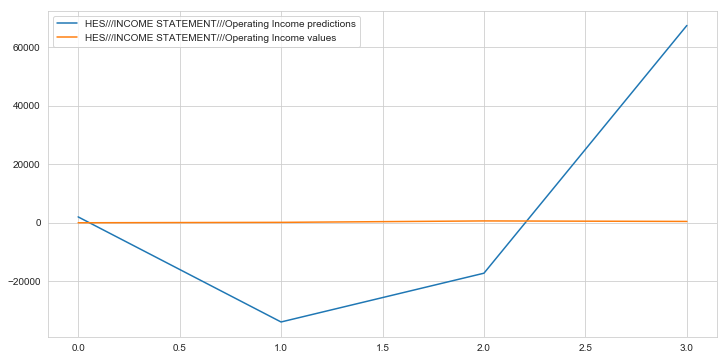

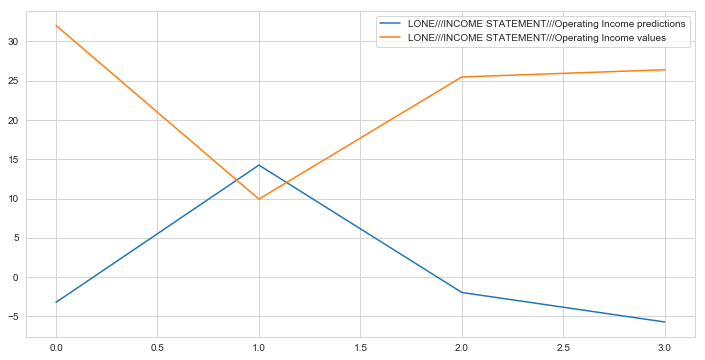

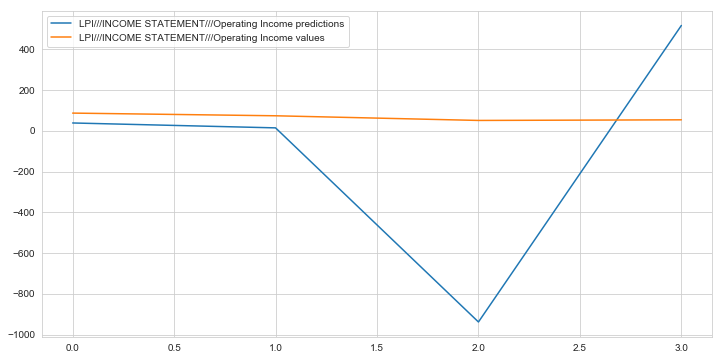

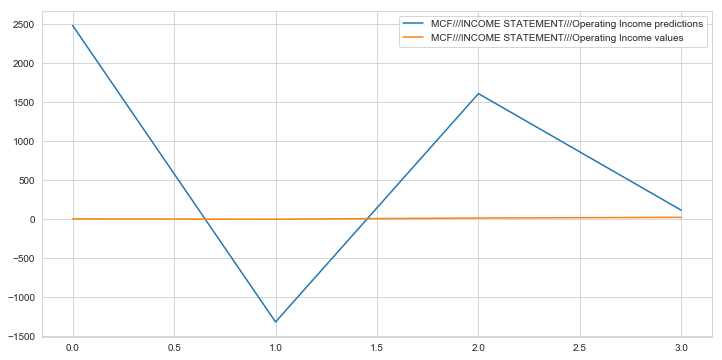

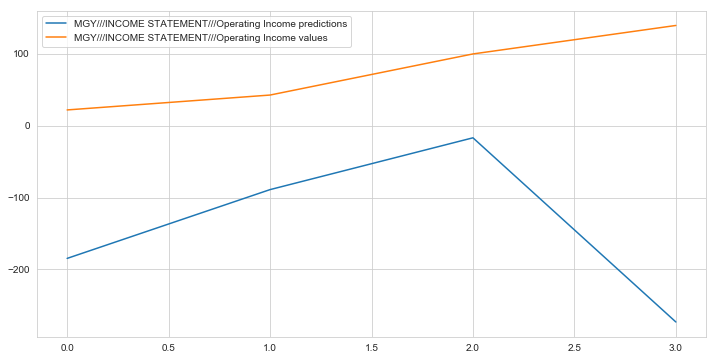

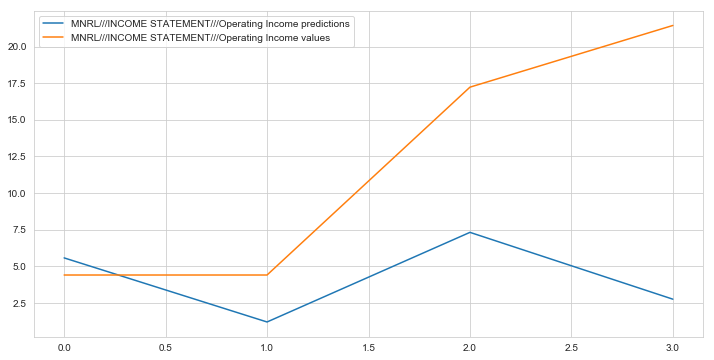

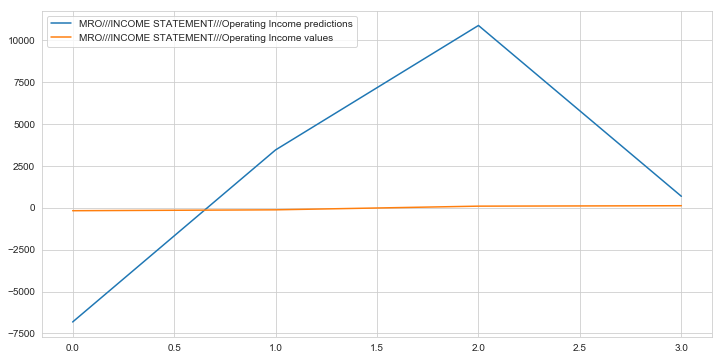

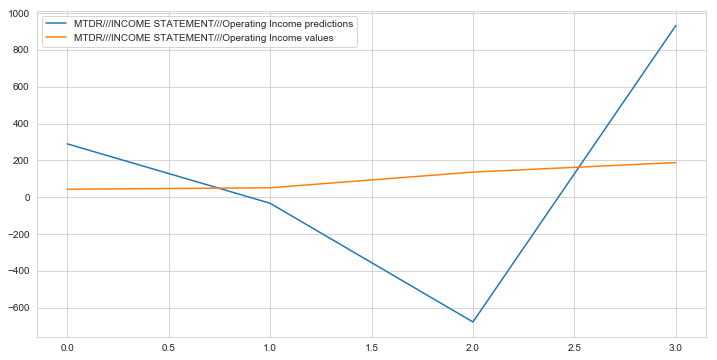

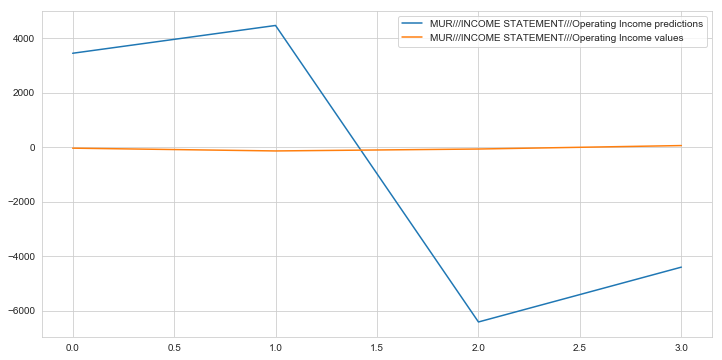

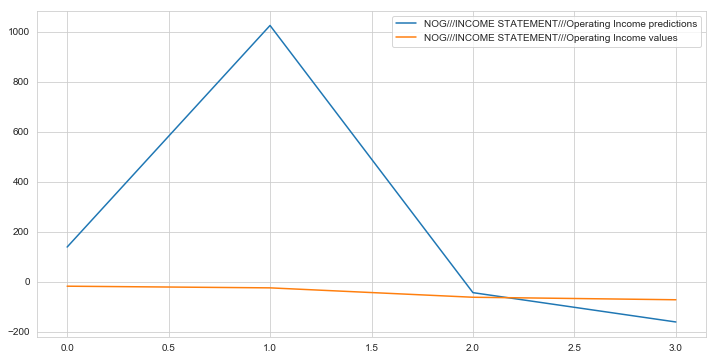

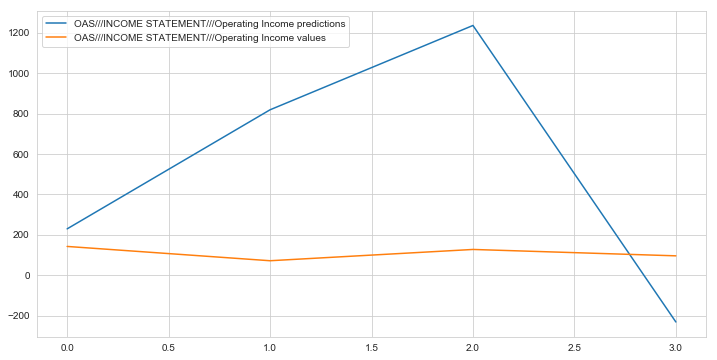

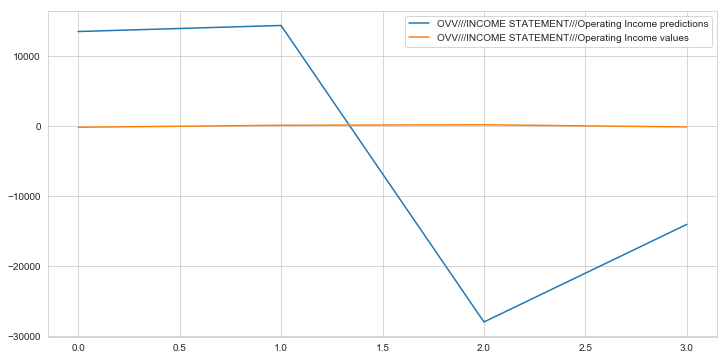

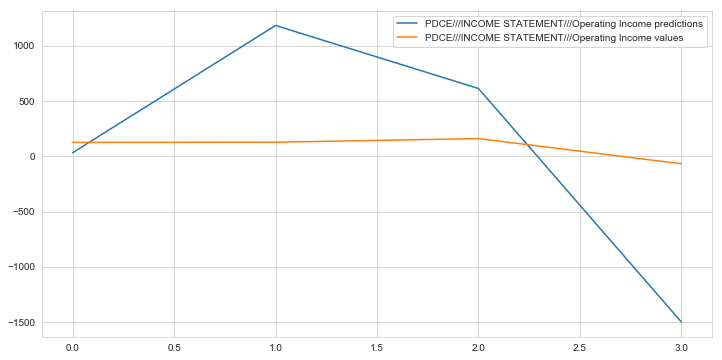

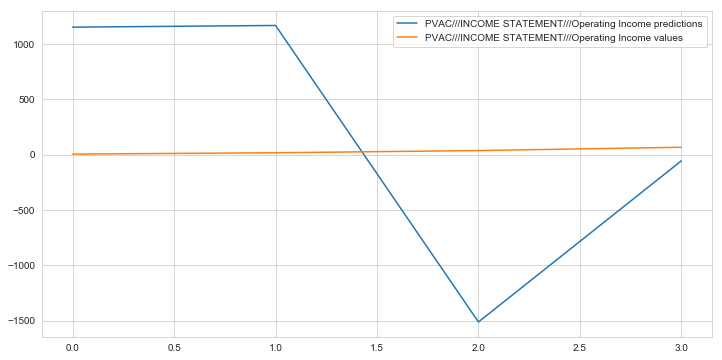

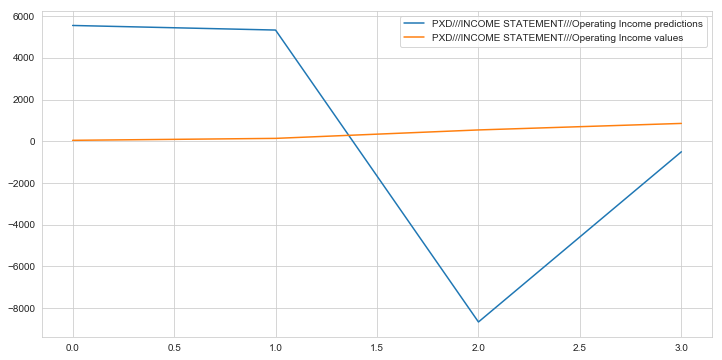

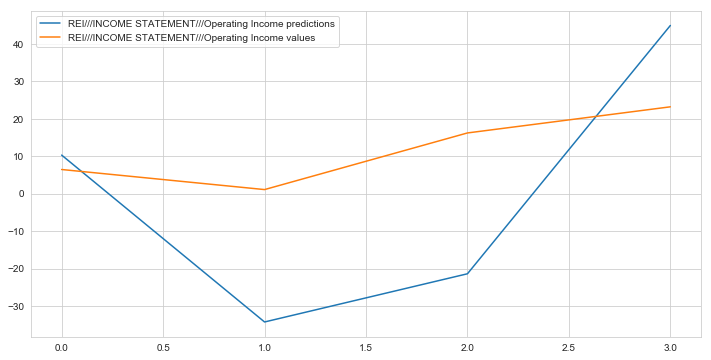

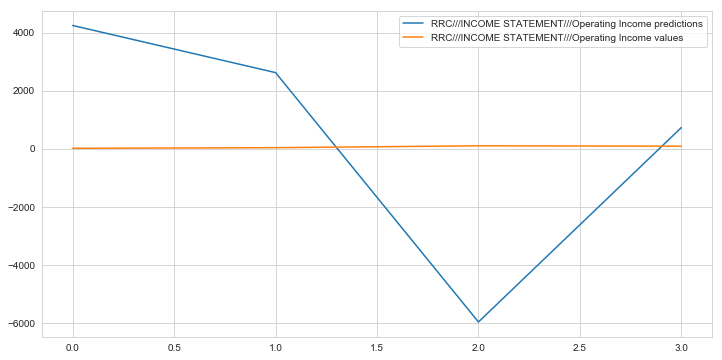

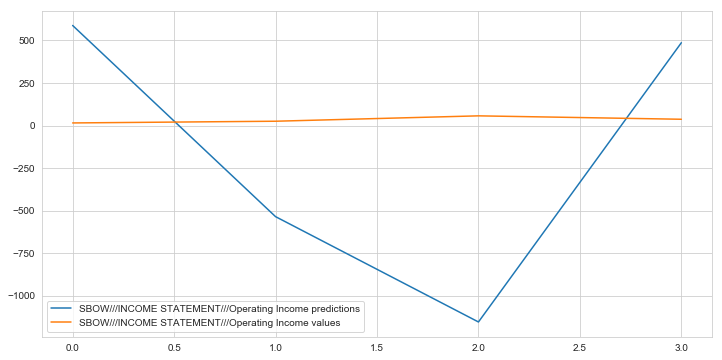

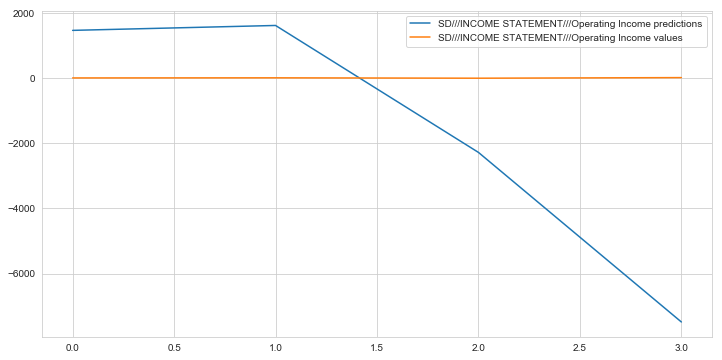

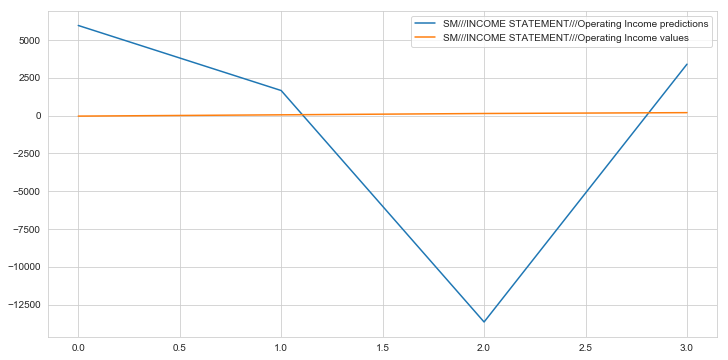

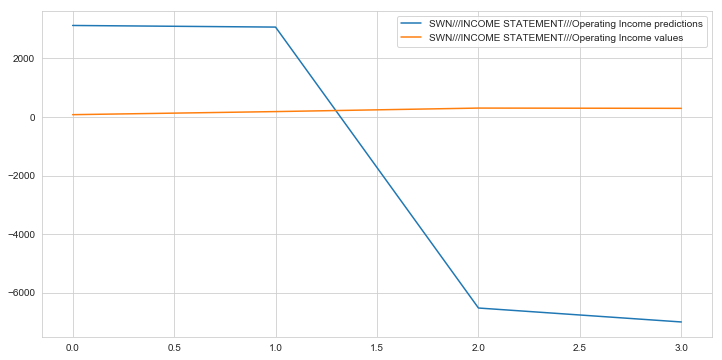

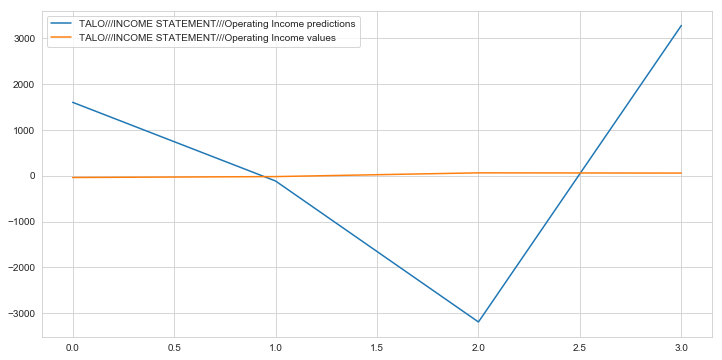

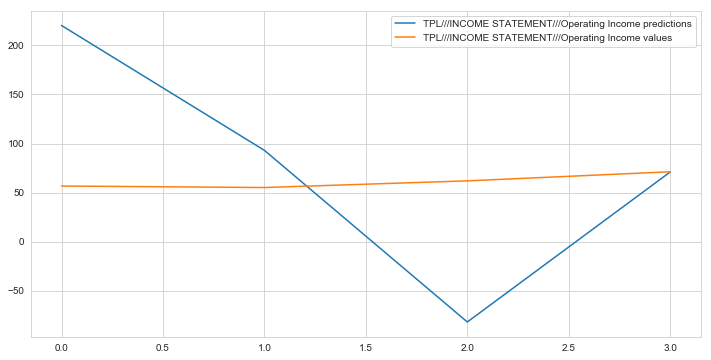

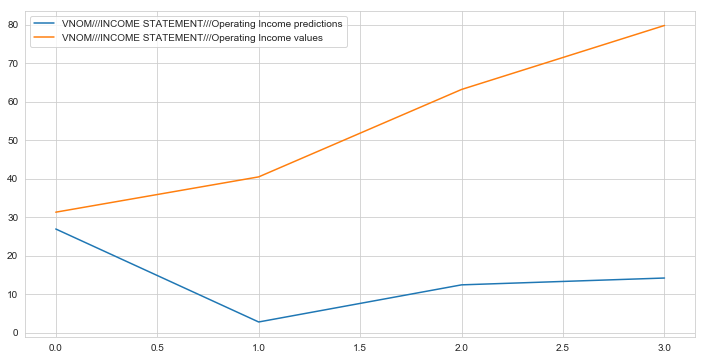

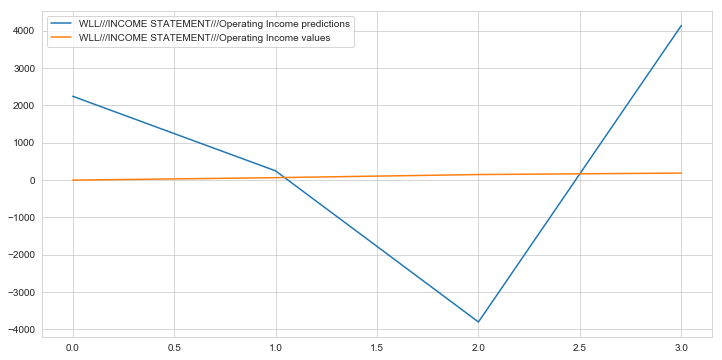

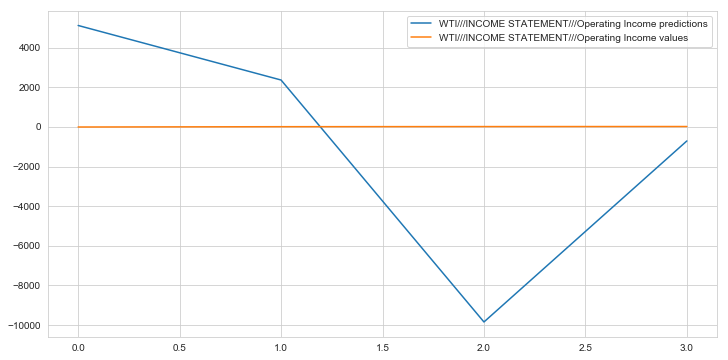

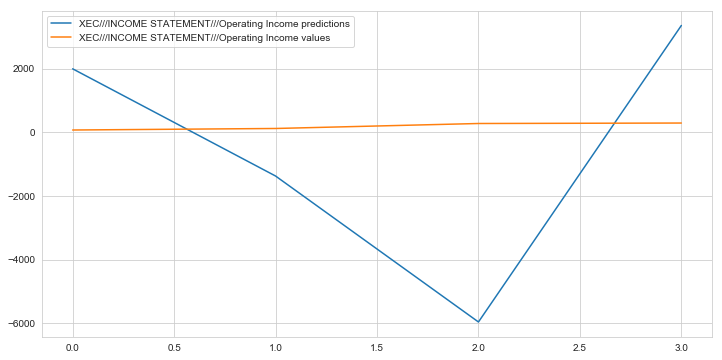

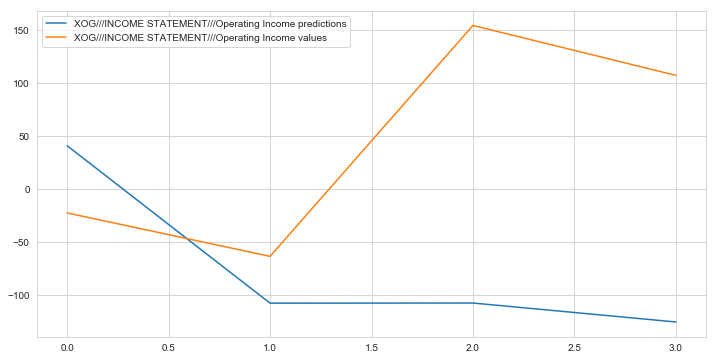

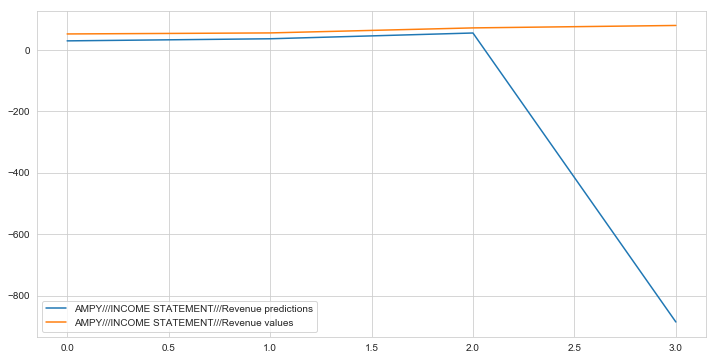

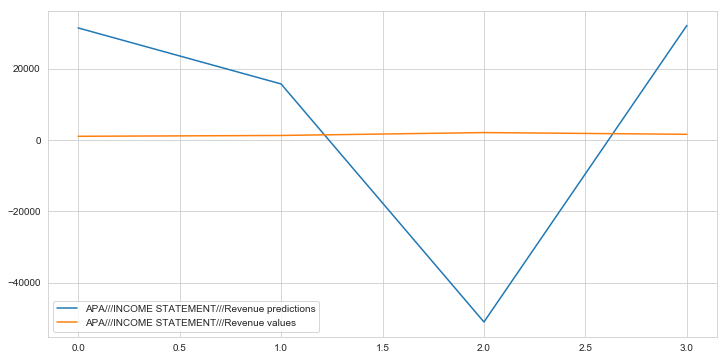

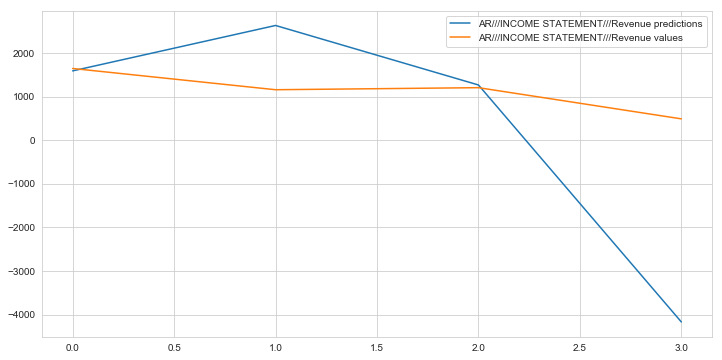

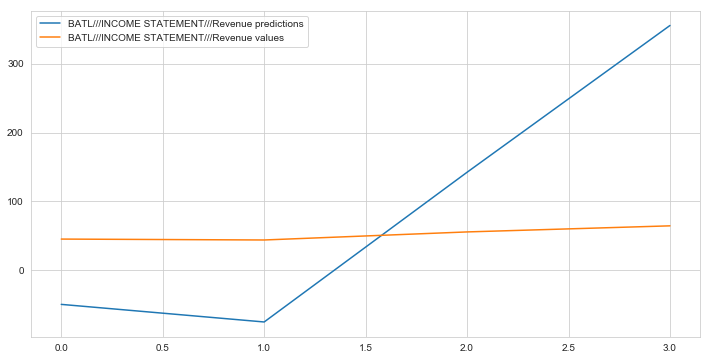

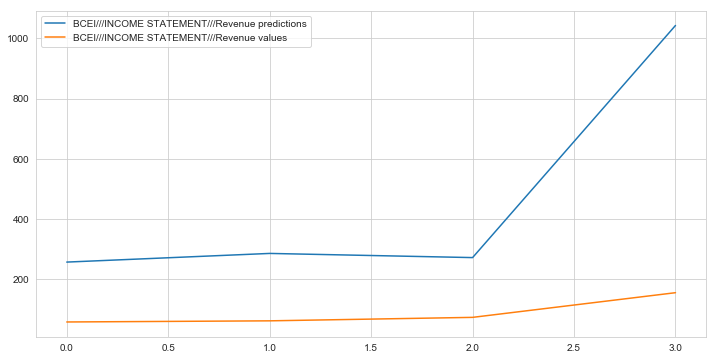

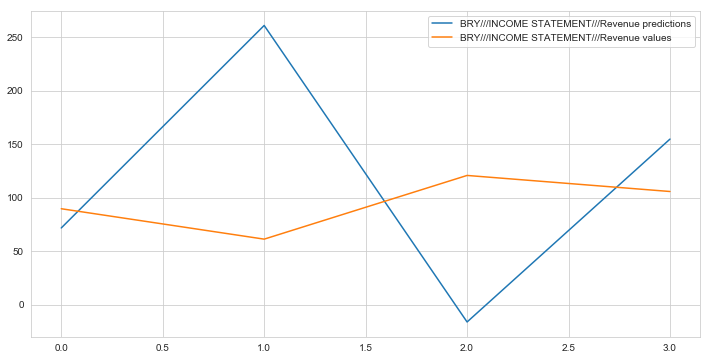

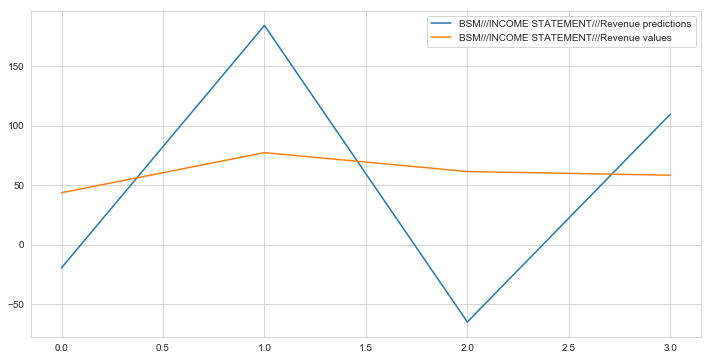

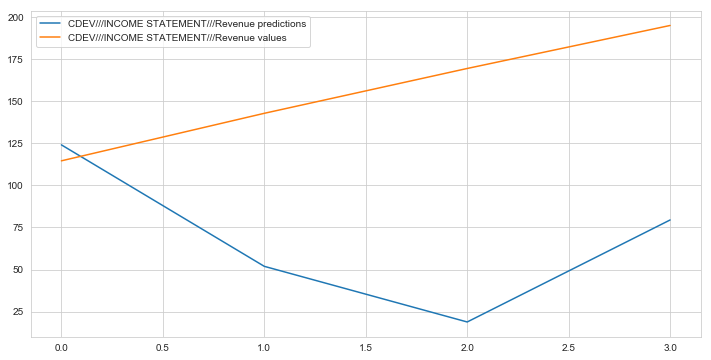

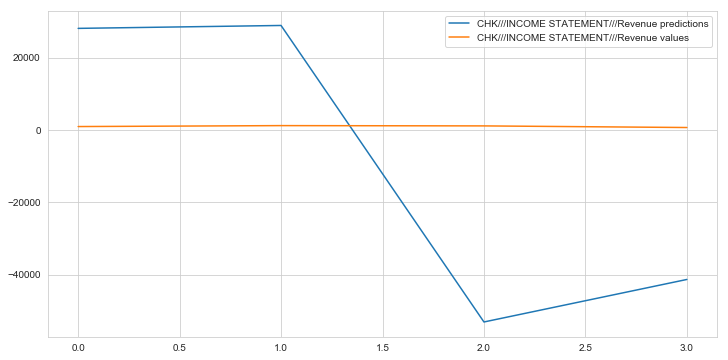

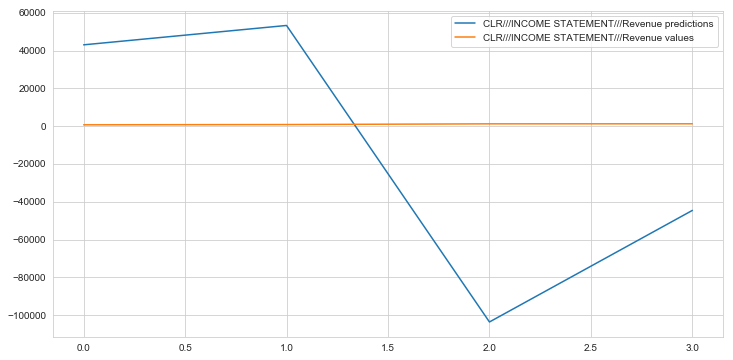

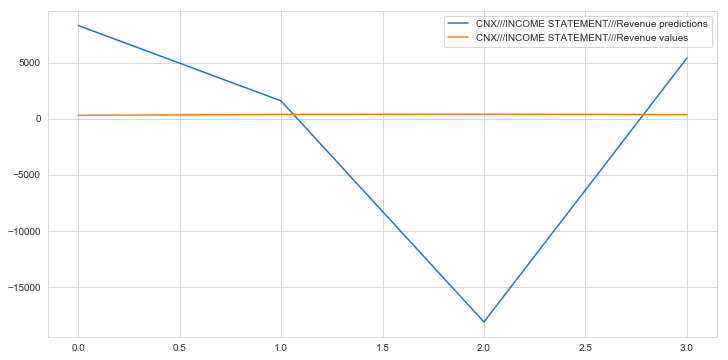

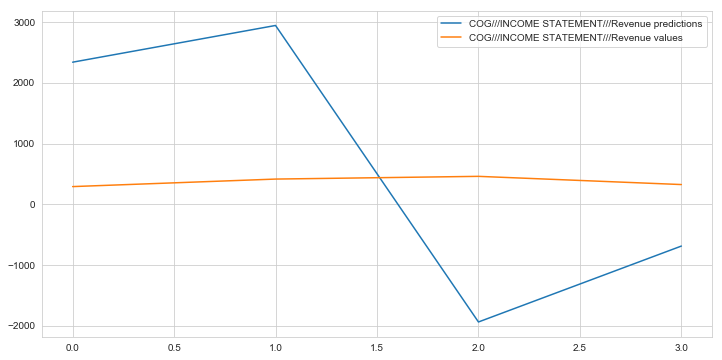

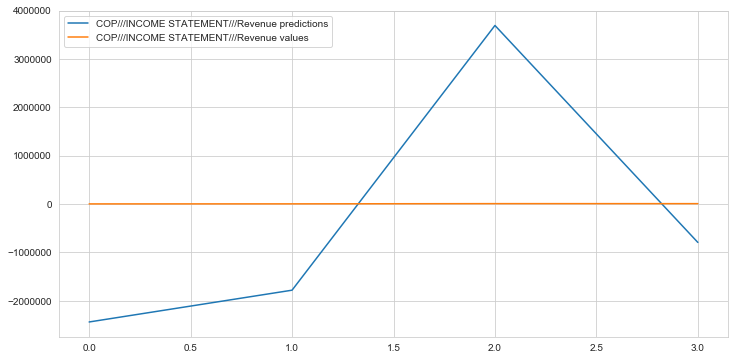

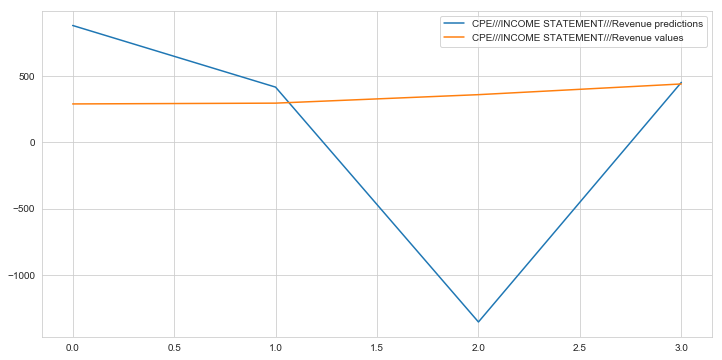

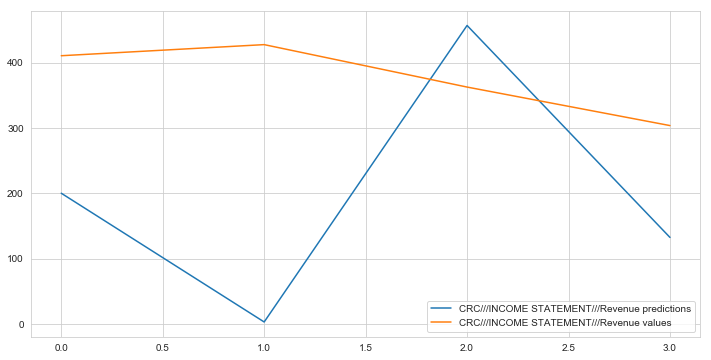

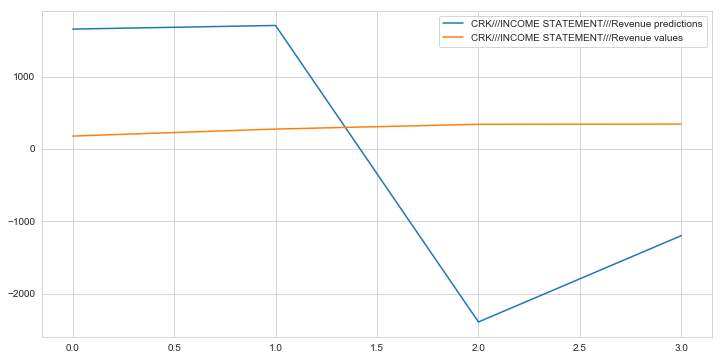

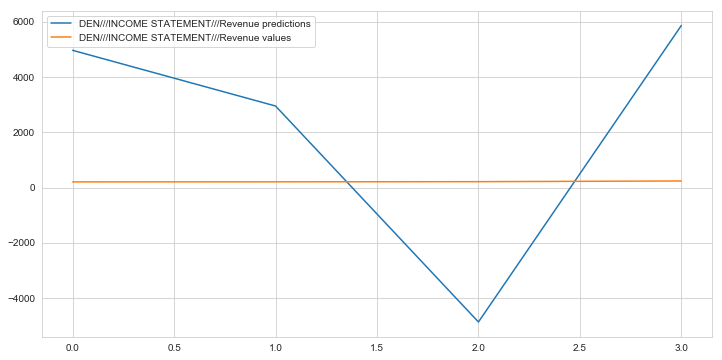

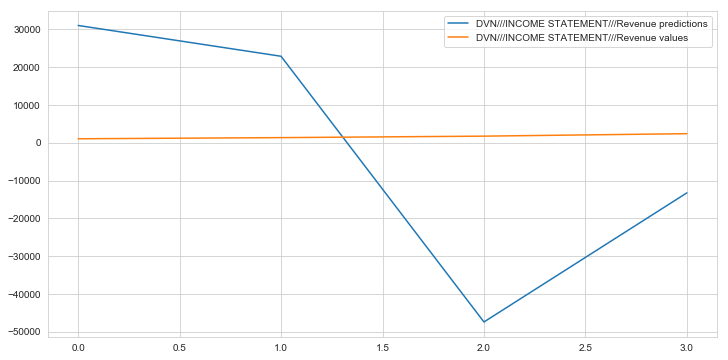

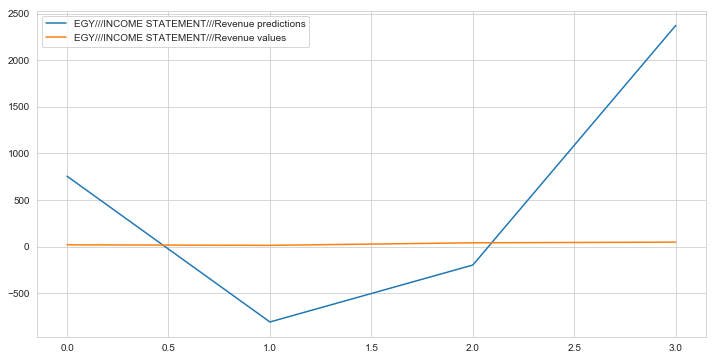

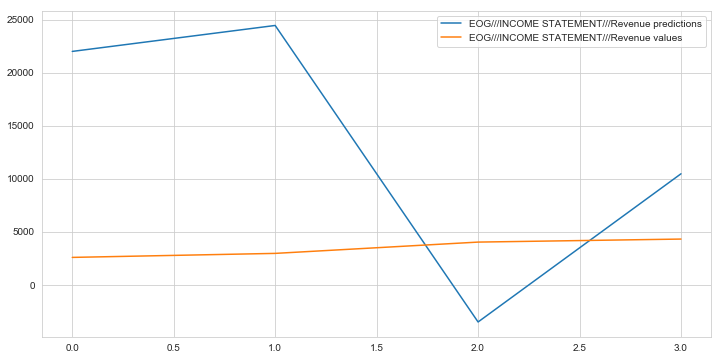

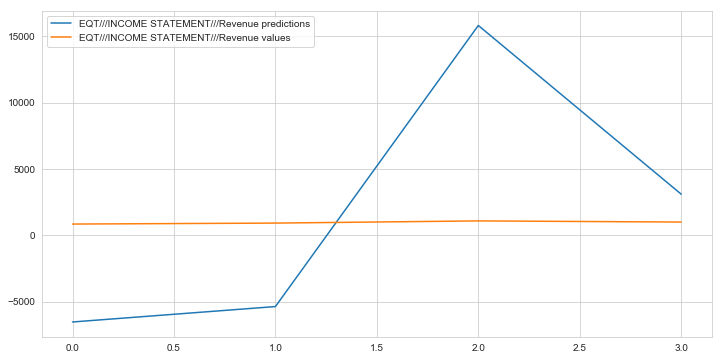

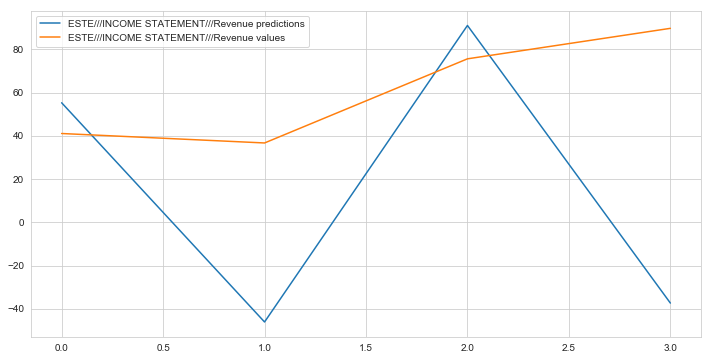

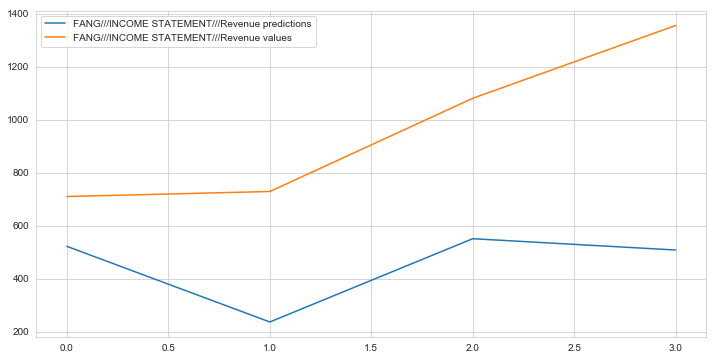

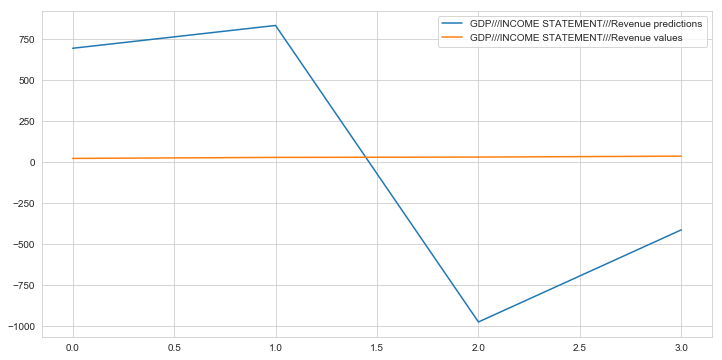

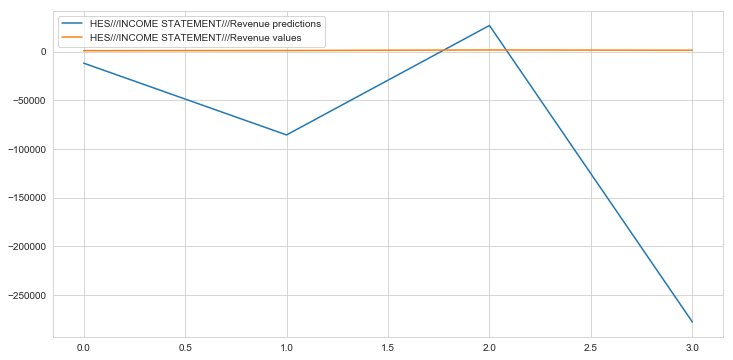

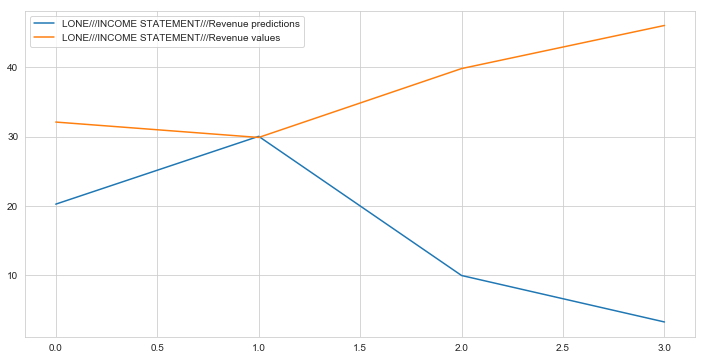

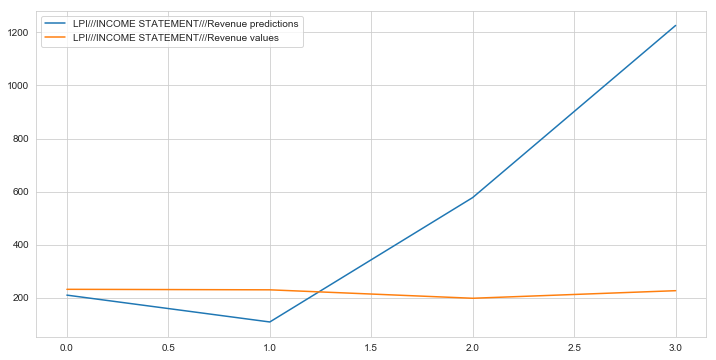

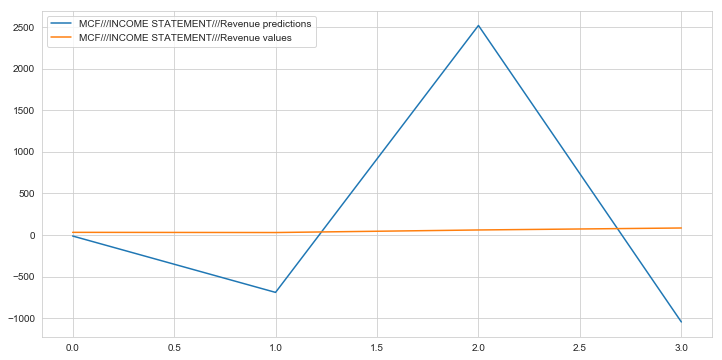

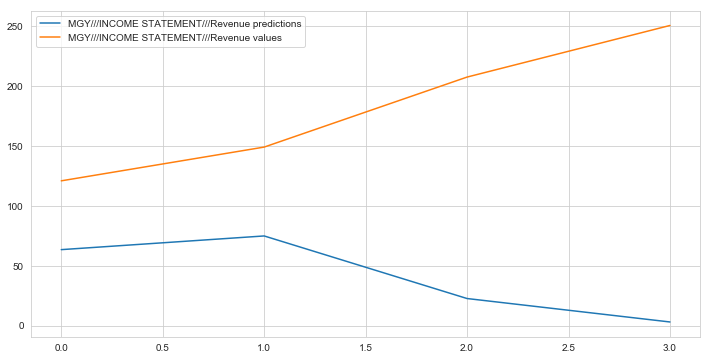

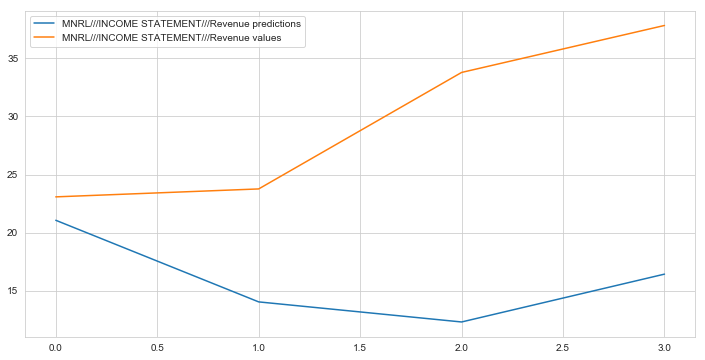

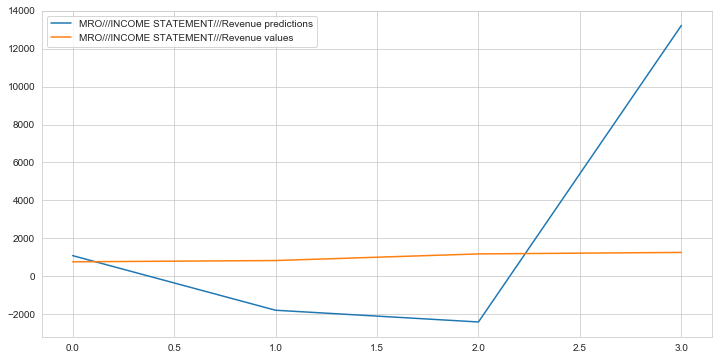

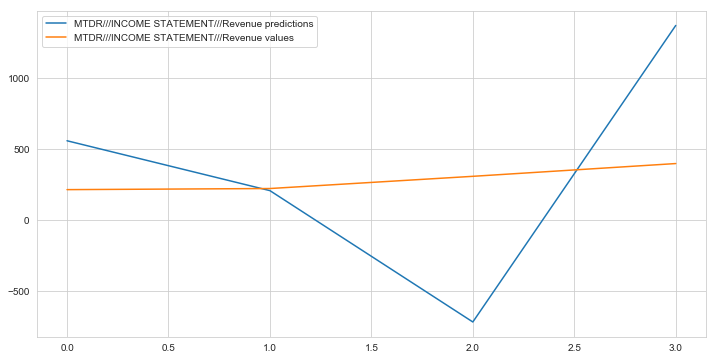

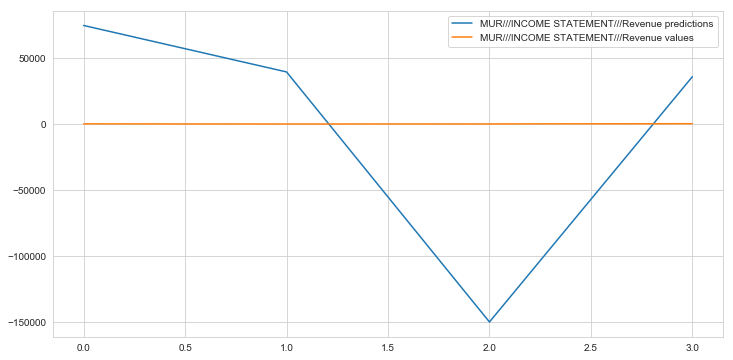

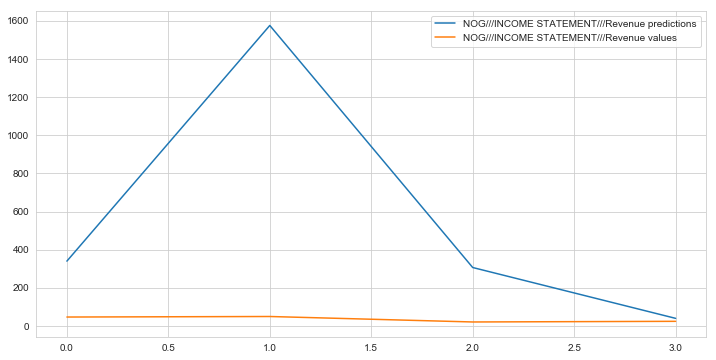

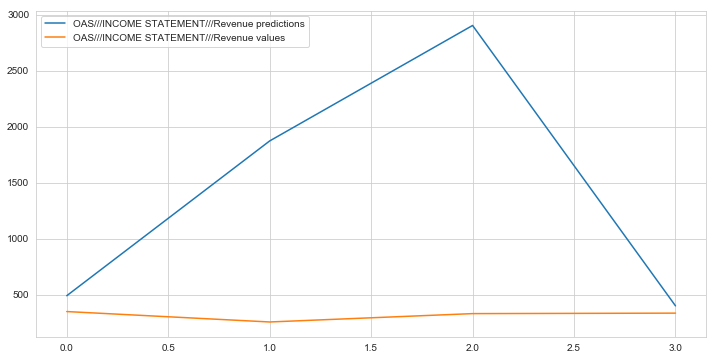

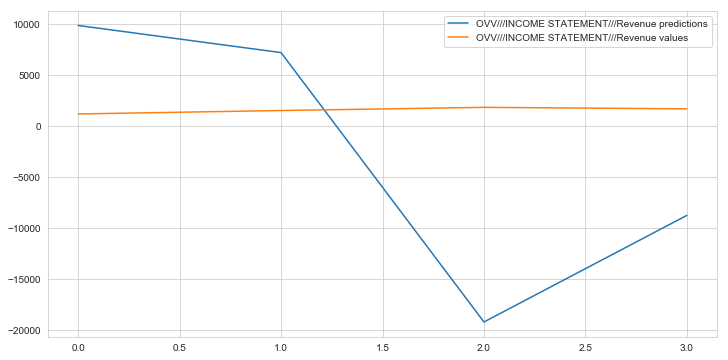

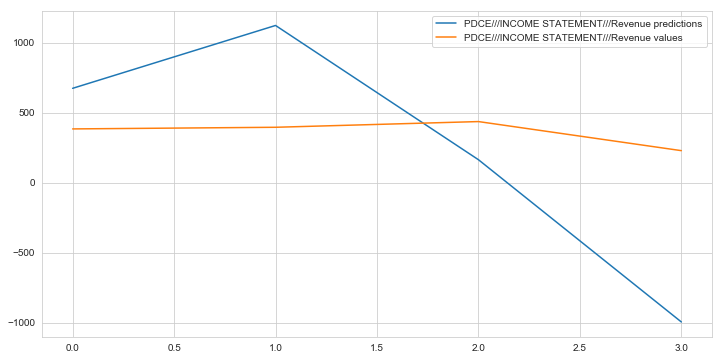

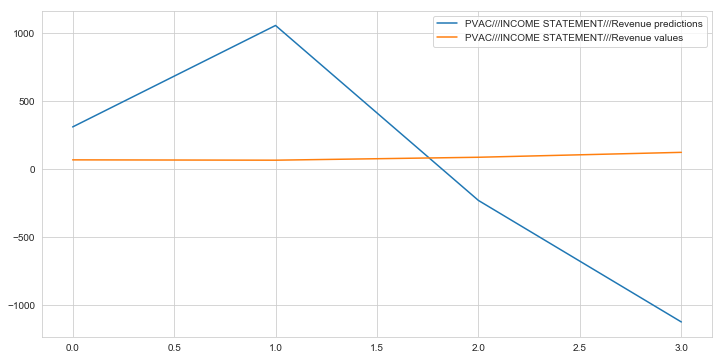

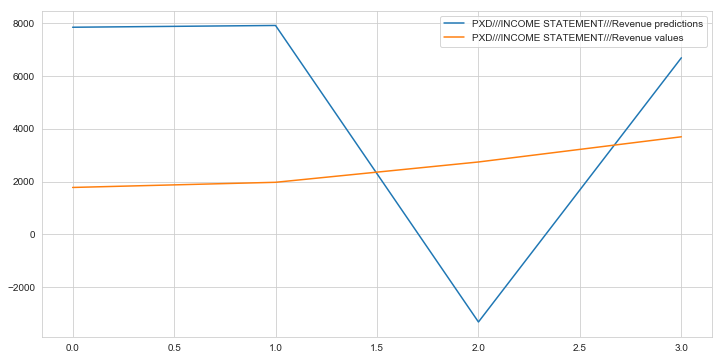

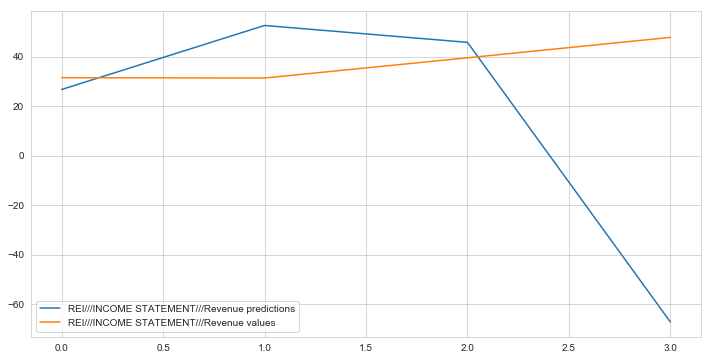

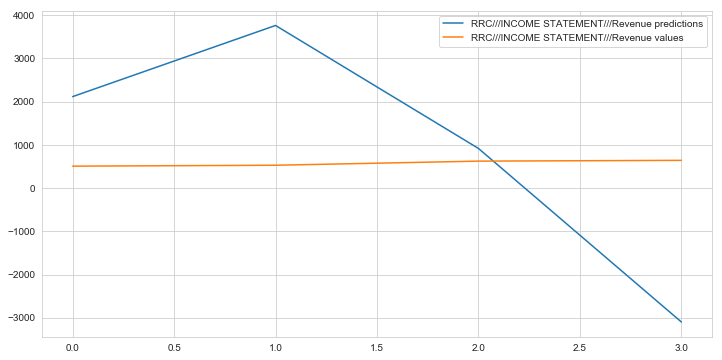

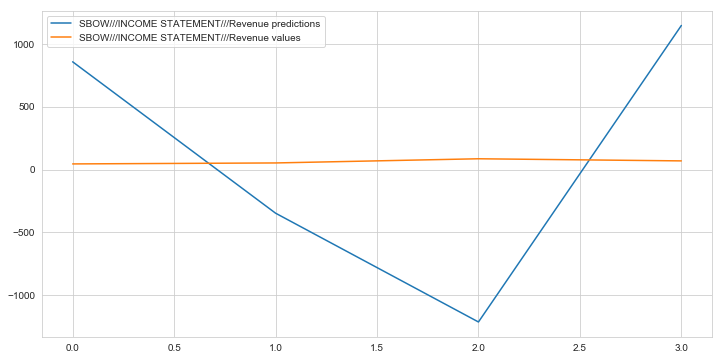

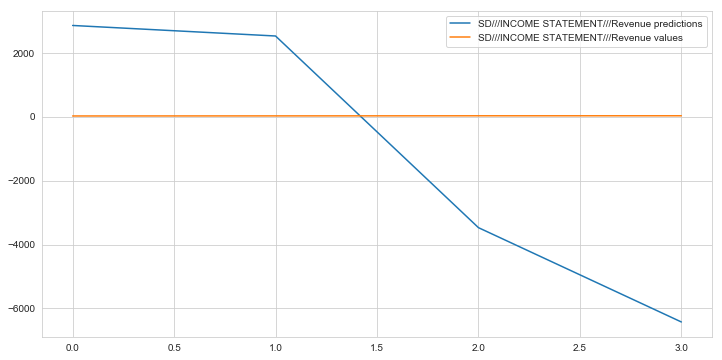

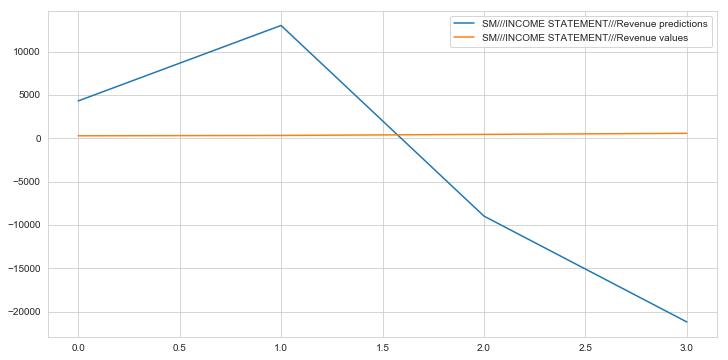

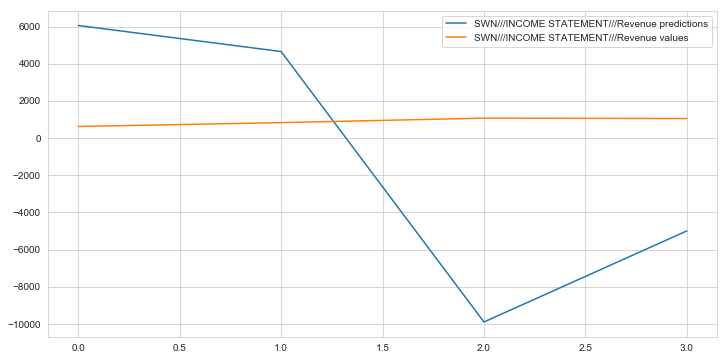

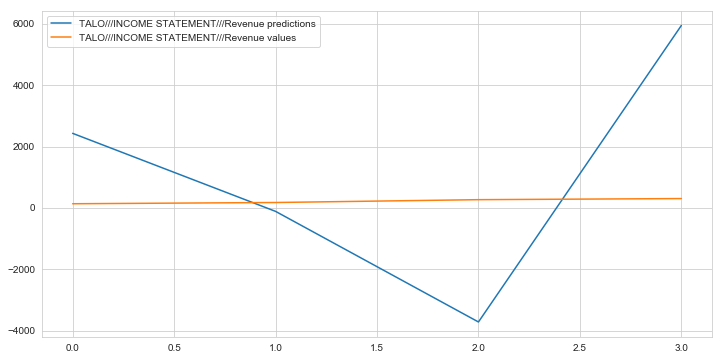

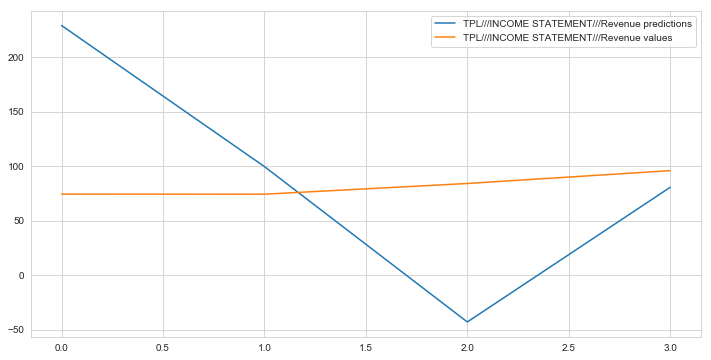

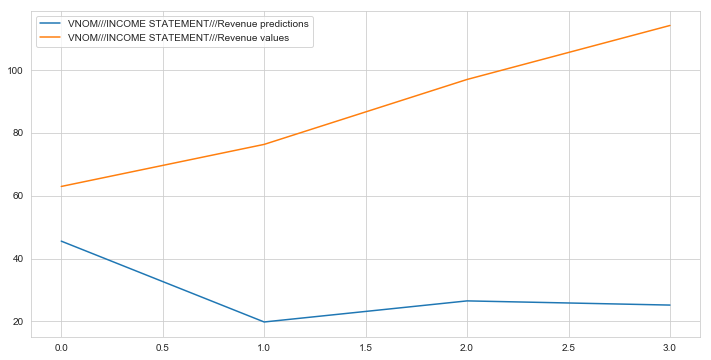

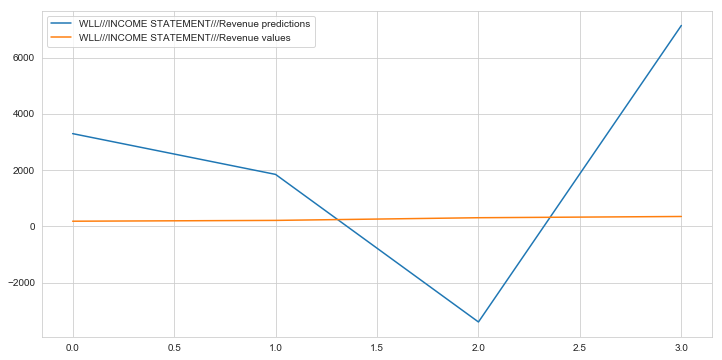

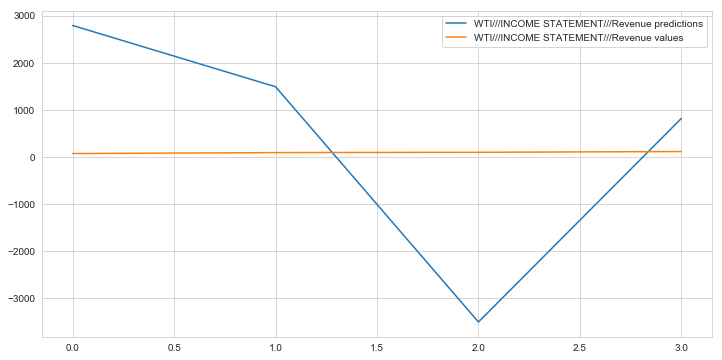

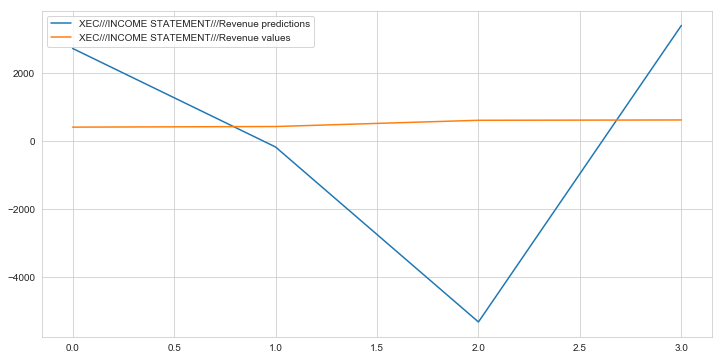

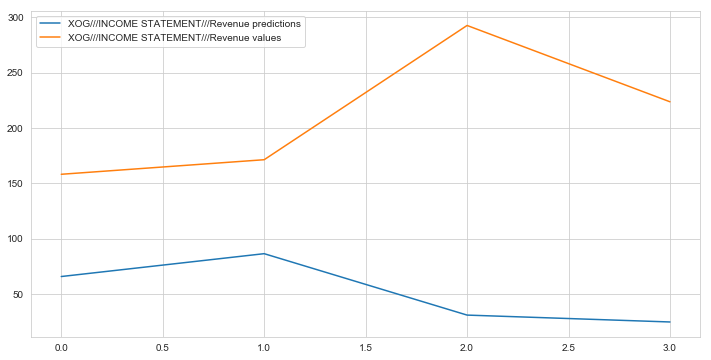

In [21]:
for i in range(var_test.values.shape[1]):
    plt.plot(forecasts[:,i], label=var_test.columns[i][0]+'///'+var_test.columns[i][1]+' predictions')
    plt.plot(var_test.values[:,i], label=var_test.columns[i][0]+'///'+var_test.columns[i][1]+' values')
    plt.legend()
    plt.show()

We see that sometimes our model succeeds in capturing the pattern. Let's calculate NMSE for each company.

In [26]:
for_df = pd.DataFrame(forecasts, index=var_test.index, columns=var_test.columns)

In [27]:
for_df

company                                   AMPY  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                          -20.158562   
2020-12-31                          -15.721294   
2021-03-31                           23.980696   
2021-06-30                         2235.885551   

company                                    APA  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                        16670.649027   
2020-12-31                         2867.841242   
2021-03-31                       -35964.740720   
2021-06-30                        17416.892401   

company                                     AR  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                          381.794475   
2020-12-31                         1052.775280   
2021-03-31                          111.770989   
2021-06-30                         -535.209339   

company                                   BATL  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                          -66.798473   
2020-12-31                          -15.636127   
2021-03-31                         -192.523777   
2021-06-30                         -879.420881   

company                                   BCEI  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                          160.584341   
2020-12-31                           24.649932   
2021-03-31                         -318.754643   
2021-06-30                          687.192158   

company                                    BRY  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                            4.674021   
2020-12-31                          184.753162   
2021-03-31                          -99.697448   
2021-06-30                           95.554898   

company                                    BSM  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                          -60.878135   
2020-12-31                          156.324955   
2021-03-31                         -100.164796   
2021-06-30                           82.035225   

company                                   CDEV  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                           32.712637   
2020-12-31                          -35.068477   
2021-03-31                          -32.837490   
2021-06-30                           41.972378   

company                                    CHK  \
           INCOME STATEMENT///Operating Income   
date                                             
2020-09-30                          244.478656   
2020-12-31                        -2112.164334   
2021-03-31                       -15020.647270   
2021-06-30                       -29748.814007   

company                                    CLR  ...  \
           INCOME STATEMENT///Operating Income  ...   
date                                            ...   
2020-09-30                        41278.456825  ...   
2020-12-31                        49800.221138  ...   
2021-03-31                      -105657.015233  ...   
2021-06-30                       -45526.413767  ...   

company                            SD                         SM  \
           INCOME STATEMENT///Revenue INCOME STATEMENT///Revenue   
date                                                               
2020-09-30                2863.465773                4301.664864   
2020-12-31                2533.444388               13010.831304   
2021-03-31               -3471.621293               -8985.736593   
2021-06-30               -6426.827019          

We could take an average to get some unique value

In [31]:
smape(var_test.stack(0).values, for_df.stack(0).values)

199.10406687653455

Let's try to take first differences.

In [32]:
var_train_test = pd.concat([var_train.iloc[:,var_train.columns.isin(var_test.columns)], var_test]).fillna(method='bfill')
test_size = len(var_test)
var_train_diff = var_train_test.diff().iloc[1:-test_size,:]
var_test_diff = var_train_test.diff().iloc[-test_size:,:]

In [33]:
var_train_diff

company                                   AMPY  \
           INCOME STATEMENT///Operating Income   
date                                             
2009-09-30                               0.000   
2009-12-31                               0.000   
2010-03-31                               0.000   
2010-06-30                               0.000   
2010-09-30                               0.000   
2010-12-31                               0.000   
2011-03-31                               0.000   
2011-06-30                               0.000   
2011-09-30                               0.000   
2011-12-31                               0.000   
2012-03-31                              34.631   
2012-06-30                               1.722   
2012-09-30                              -0.390   
2012-12-31                              17.006   
2013-03-31                              -7.620   
2013-06-30                              -3.113   
2013-09-30                              14.745   
2013-12-31                              12.012   
2014-03-31                               6.080   
2014-06-30                               6.293   
2014-09-30                               7.354   
2014-12-31                              -5.703   
2015-03-31                             -10.826   
2015-06-30                               1.034   
2015-09-30                              -6.887   
2015-12-31                              -3.783   
2016-03-31                             -35.030   
2016-06-30                              22.924   
2016-09-30                               4.571   
2016-12-31                              -6.915   
2017-03-31                              -1.219   
2017-06-30                              -7.120   
2017-09-30                               4.335   
2017-12-31                              -3.049   
2018-03-31                               0.988   
2018-06-30                               1.675   
2018-09-30                             -28.378   
2018-12-31                              34.262   
2019-03-31                             -12.618   
2019-06-30                              -0.616   
2019-09-30                              -4.772   
2019-12-31                               9.095   
2020-03-31                              -7.277   
2020-06-30                             -16.529   

company                                    APA  \
           INCOME STATEMENT///Operating Income   
date                                             
2009-09-30                            0.000000   
2009-12-31                            0.000000   
2010-03-31                            0.000000   
2010-06-30                            0.000000   
2010-09-30                            0.000000   
2010-12-31                            0.000000   
2011-03-31                            0.000000   
2011-06-30                          253.000064   
2011-09-30                         -118.000128   
2011-12-31                          -73.999872   
2012-03-31                           52.000000   
2012-06-30                         -646.000128   
2012-09-30                          116.000000   
2012-12-31                          247.000064   
2013-03-31                         -212.000000   
2013-06-30                         -123.000064   
2013-09-30                          179.000064   
2013-12-31                         -402.000000   
2014-03-31                          136.000000   
2014-06-30                         -186.999936   
2014-09-30                          170.999936   
2014-12-31                         -646.000000   
2015-03-31                         -858.000000   
2015-06-30                          420.000000   
2015-09-30                         -369.000000   
2015-12-31                         -253.000000   
2016-03-31                          123.000000   
2016-06-30                          206.000000   
2016-09-30                          145.000000   
2016-12-31                            5.000000   

In [34]:
model = VAR(var_train_diff, dates=var_train_diff.index)
results = model.fit()

No frequency information was provided, so inferred frequency Q-DEC will be used.


In [35]:
lag_order = results.k_ar
forecasts = results.forecast(var_train_diff.values[-lag_order:], 4)
for_df = pd.DataFrame(forecasts, index=var_test.index, columns=var_test_diff.columns)

In [37]:
smape(var_test_diff.stack(0).values, for_df.stack(0).values)

199.8044279035426

### VARMAX model

The value of our metric has decreased. Now, let's also try to use exogenous values here.

In [38]:
var_train = data_train.copy()
var_test = data_test.copy()

In [39]:
var_train = var_train.set_index(['company','date']).unstack(0)
var_test = var_test.set_index(['company','date']).unstack(0)

In [40]:
var_train = var_train.reorder_levels(order=[1,0], axis=1)
var_test = var_test.reorder_levels(order=[1,0], axis=1)

In [41]:
var_train.fillna(method='bfill', inplace=True)
var_test.fillna(method='bfill', inplace=True)

In [42]:
var_target = [x for x in var_test.columns if x[1] in target]
var_exog = [x for x in var_test.columns if x[1] not in target]

In [43]:
model = VAR(var_train[var_target], dates=var_train.index, exog=var_train[var_exog])
results = model.fit()

No frequency information was provided, so inferred frequency Q-DEC will be used.


In [44]:
lag_order = results.k_ar
forecasts = results.forecast(var_train[var_target].values[-lag_order:], 4, exog_future=var_test[var_exog].values)
for_df = pd.DataFrame(forecasts, index=var_test.index, columns=var_test[var_target].columns)

In [46]:
smape(for_df.stack(0).values,var_test[var_target].stack(0).values)

72.63125956070363

Let's again consider model with differences.

In [47]:
var_train_test = pd.concat([var_train.iloc[:,var_train.columns.isin(var_test.columns)], var_test])
test_size = len(var_test)
var_train_diff = var_train_test.diff().iloc[1:-test_size,:]
var_test_diff = var_train_test.diff().iloc[-test_size:,:]

In [48]:
model = VAR(var_train_diff[var_target], dates=var_train_diff.index, exog=var_train_diff[var_exog])
results = model.fit()

No frequency information was provided, so inferred frequency Q-DEC will be used.


In [49]:
lag_order = results.k_ar
forecasts = results.forecast(var_train_diff[var_target].values[-lag_order:], 4, exog_future=var_test_diff[var_exog])
for_df = pd.DataFrame(forecasts, index=var_test_diff.index, columns=var_test_diff[var_target].columns)

In [51]:
smape(var_test_diff[var_target].stack(0).values, for_df.stack(0).values)

115.71975702769632

We see that VARMAX model performe slightly better than the VARMA.

## Supervised machine learning

### XGBoost

In [52]:
train, test = data_train.copy(), data_test.copy()

In [53]:
train.shape, test.shape

((1816, 37), (208, 37))

In [54]:
train.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [55]:
train['company'] = train['company'].astype("category")
test['company'] = test['company'].astype("category")

In [56]:
# reorder features in test
test = test[train.columns]

In [57]:
X_train, y_train = train.loc[:,~train.columns.isin(target)], train.loc[:,train.columns.isin(target)]
X_test, y_test = test.loc[:,~test.columns.isin(target)], test.loc[:,test.columns.isin(target)]

In [77]:
Xy_train_d = xgb.DMatrix(X_train, y_train[target], enable_categorical=True)
X_test_d = xgb.DMatrix(X_test, enable_categorical=True)
booster = xgb.train({"tree_method": "hist", "max_cat_to_onehot": 5}, Xy_train_d,
                    custom_metric=smape, maximize=False)

In [78]:
preds = booster.predict(X_test_d)

In [60]:
preds.shape, y_test.shape

((208, 2), (208, 2))

In [79]:
smape(y_test.values, preds)

26.405689066992455

Wow! That's much better

If we scale the data

In [63]:
scalerX = StandardScaler().fit(X_train.loc[:,~X_train.columns.isin(['company'])])
train_for_scale = X_train.loc[:,~X_train.columns.isin(['company'])]
test_for_scale = X_test.loc[:,~X_test.columns.isin(['company'])]
X_train_scaled = pd.DataFrame(scalerX.transform(train_for_scale), index=train_for_scale.index, columns=train_for_scale.columns)
X_test_scaled = pd.DataFrame(scalerX.transform(test_for_scale), index=test_for_scale.index, columns=test_for_scale.columns)
X_train_scaled = pd.concat([X_train_scaled, X_train['company']], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test['company']], axis=1)

In [64]:
X_train_scaled.shape, X_test_scaled.shape

((1816, 34), (208, 34))

In [80]:
Xy_train_d = xgb.DMatrix(X_train_scaled, y_train, enable_categorical=True)
X_test_d = xgb.DMatrix(X_test_scaled, enable_categorical=True)
booster = xgb.train({"tree_method": "hist", "max_cat_to_onehot": 5}, Xy_train_d,
                    custom_metric=smape, maximize=False)

In [81]:
preds = booster.predict(X_test_d)
smape(y_test.values, preds)

24.620586043206497

Even more better! Let's make a visualization of our predictions.

In [82]:
y_test_ = pd.concat([y_test.reset_index(), X_test_scaled.reset_index()['company']], axis=1).set_index('date')
xgb_preds = pd.concat([pd.DataFrame(preds, columns=y_test.columns), X_test_scaled.reset_index().loc[:,['company','date']]], axis=1).set_index('date')

In [68]:
xgb_preds.head()

INCOME STATEMENT///Operating Income  INCOME STATEMENT///Revenue  \
date                                                                          
2020-09-30                           -32.418320                  133.223099   
2020-12-31                           -22.444214                  125.987305   
2021-03-31                            38.178089                  147.922775   
2021-06-30                            38.178089                  177.179642   
2020-09-30                            -1.912911                  289.824402   

           company  
date                
2020-09-30    CDEV  
2020-12-31    CDEV  
2021-03-31    CDEV  
2021-06-30    CDEV  
2020-09-30     COG

In [69]:
y_test_.head()

INCOME STATEMENT///Operating Income  INCOME STATEMENT///Revenue  \
date                                                                          
2020-09-30                              -46.011                  114.615000   
2020-12-31                              -11.545                  142.859008   
2021-03-31                               32.885                  169.504992   
2021-06-30                               48.578                  195.064000   
2020-09-30                               -7.564                  291.040992   

           company  
date                
2020-09-30    CDEV  
2020-12-31    CDEV  
2021-03-31    CDEV  
2021-06-30    CDEV  
2020-09-30     COG

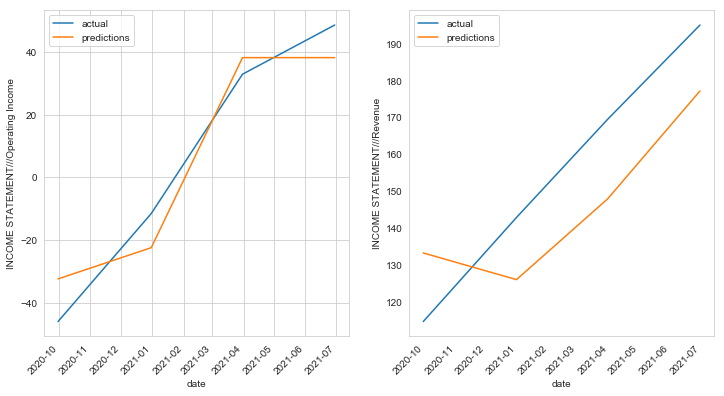

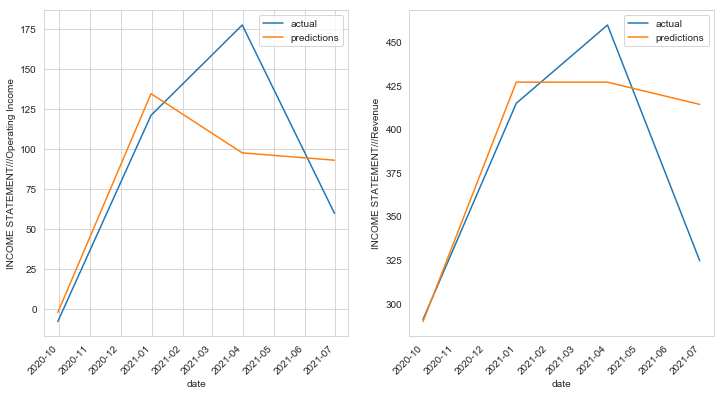

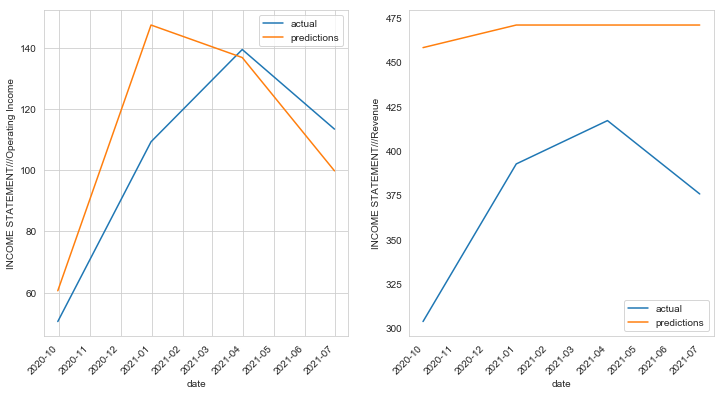

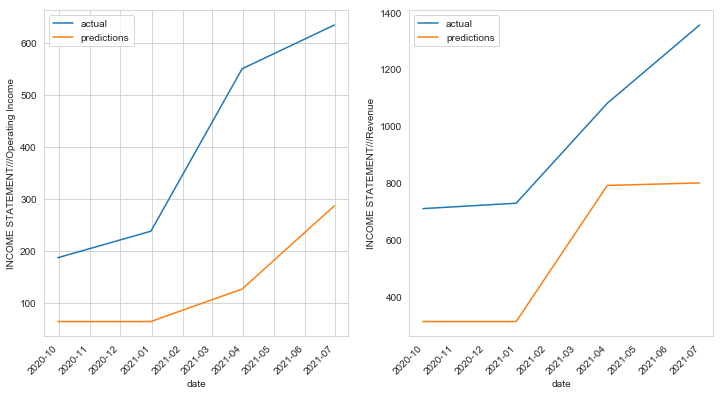

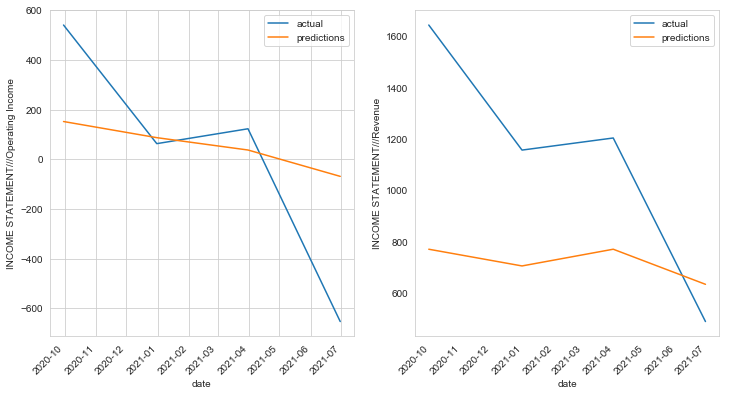

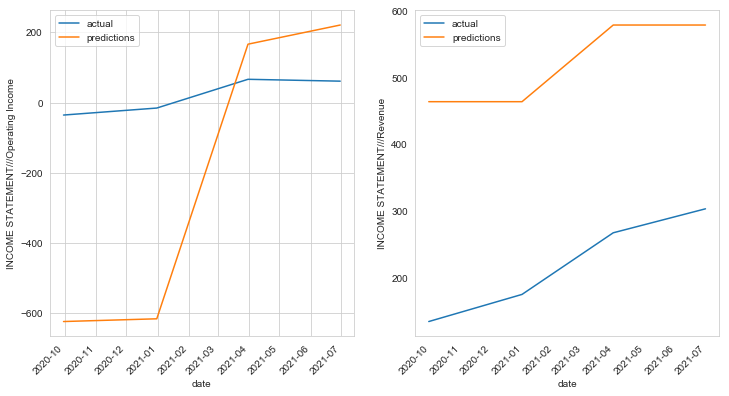

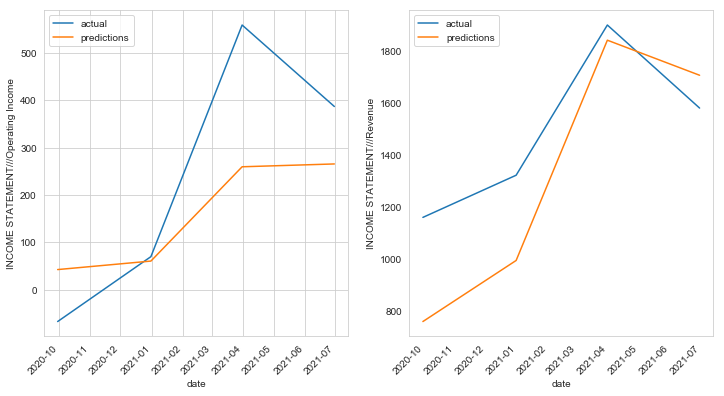

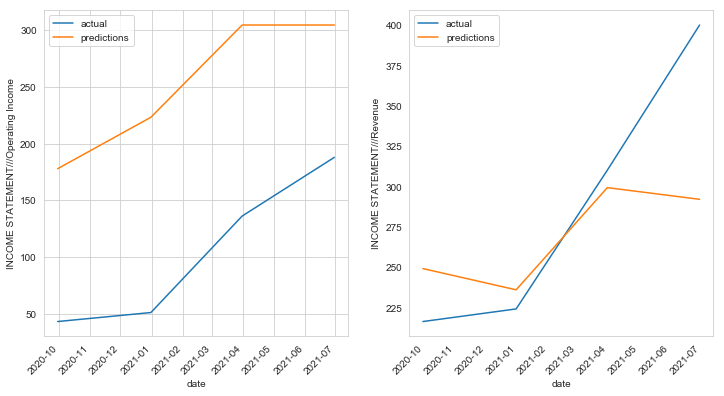

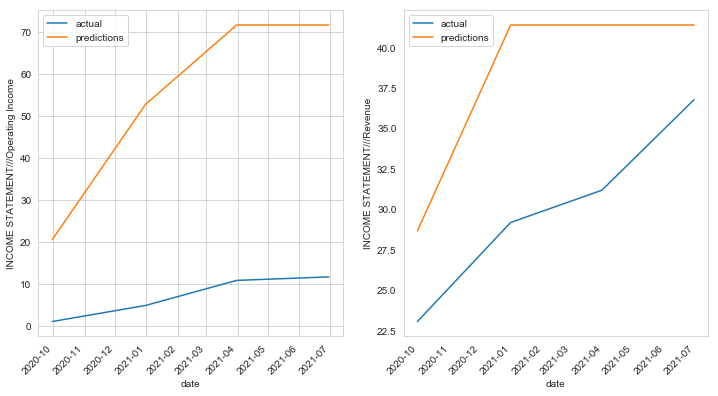

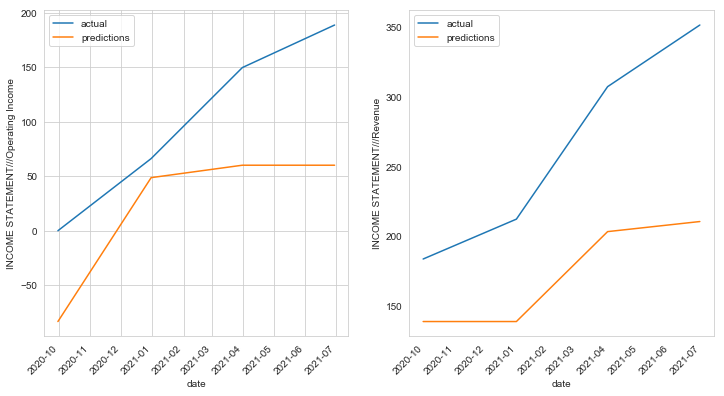

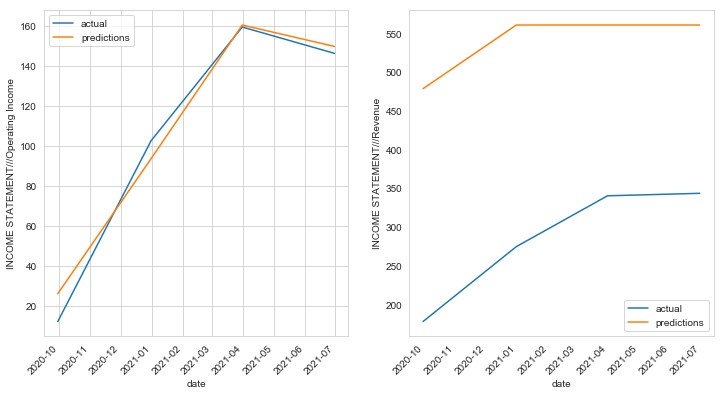

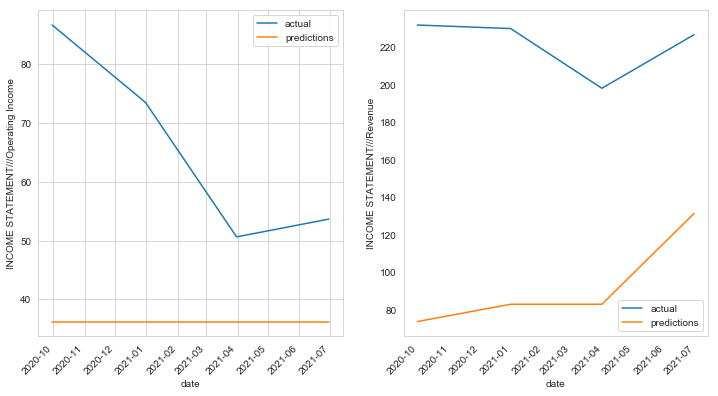

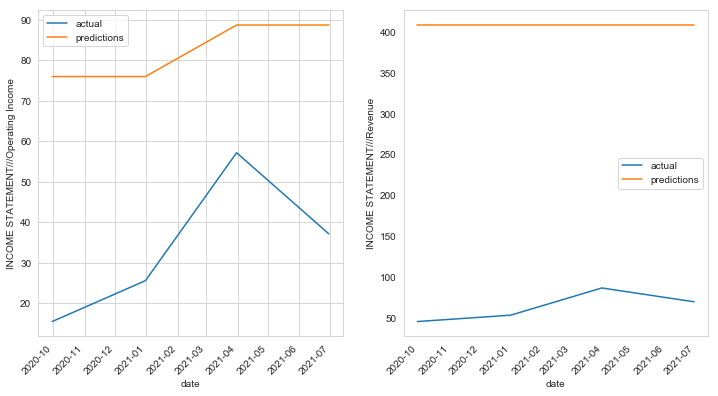

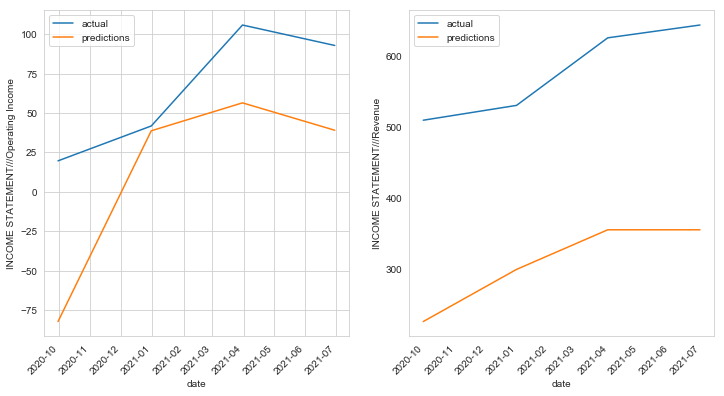

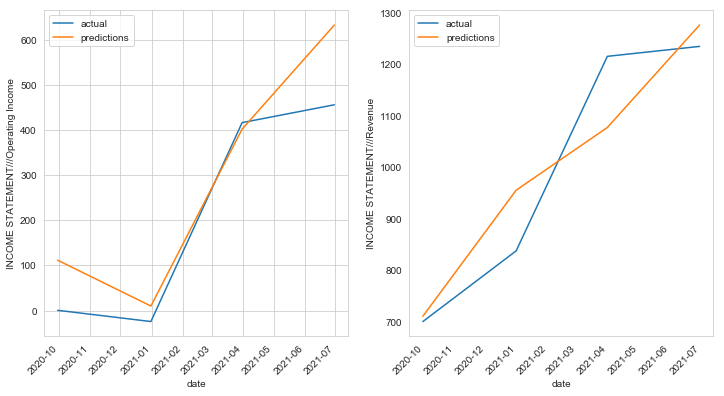

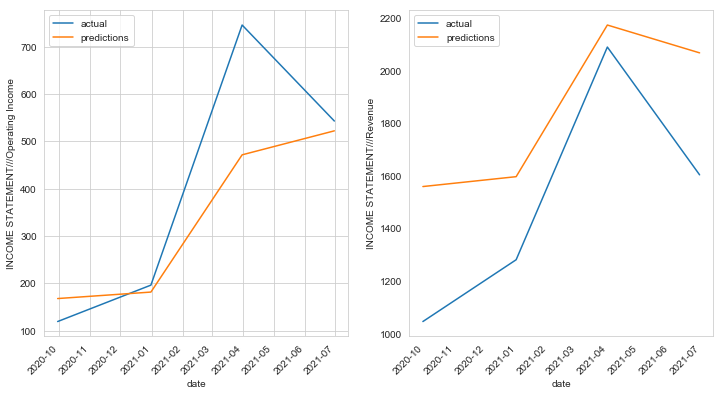

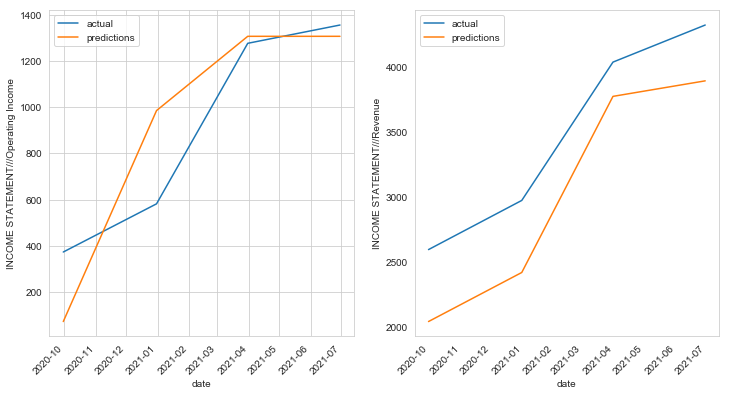

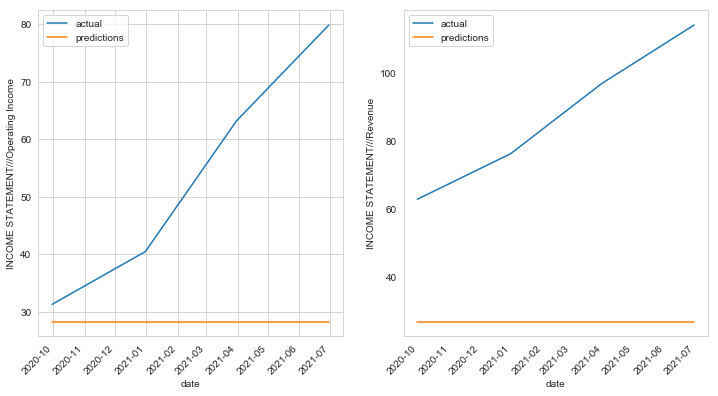

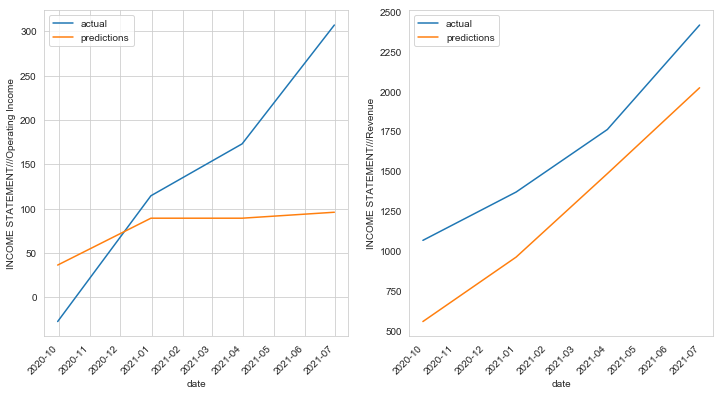

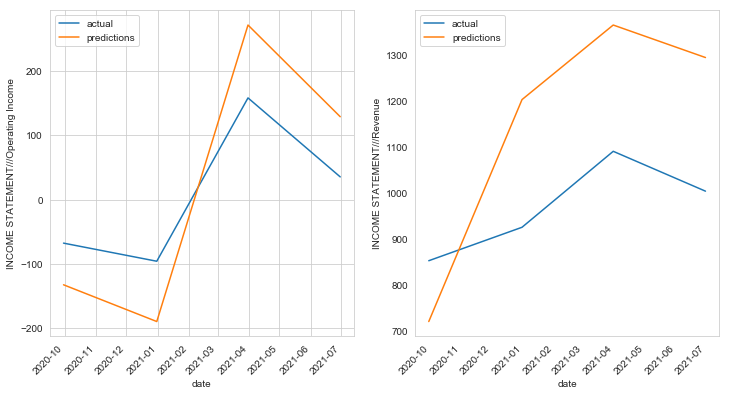

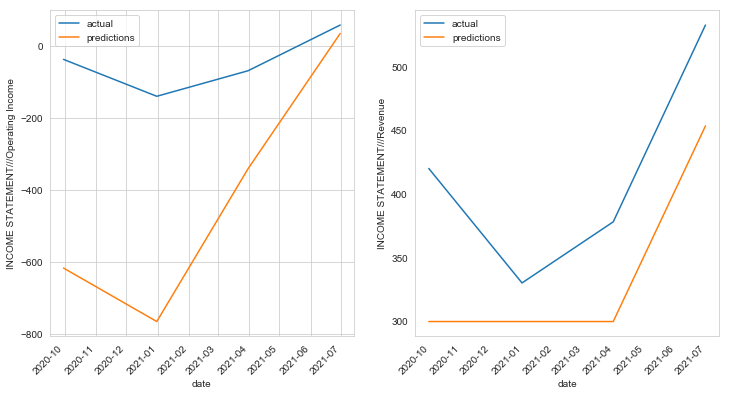

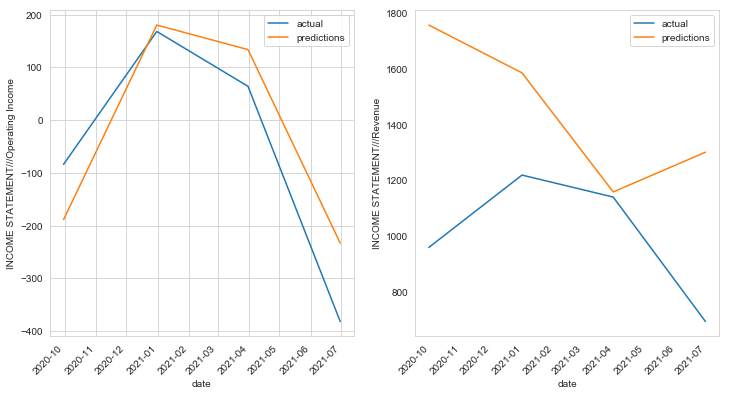

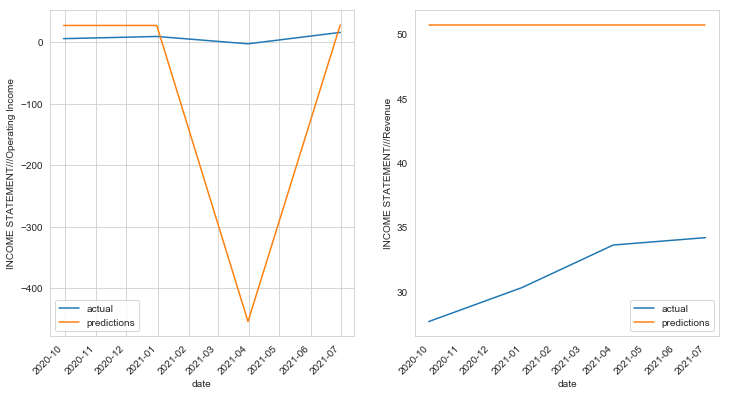

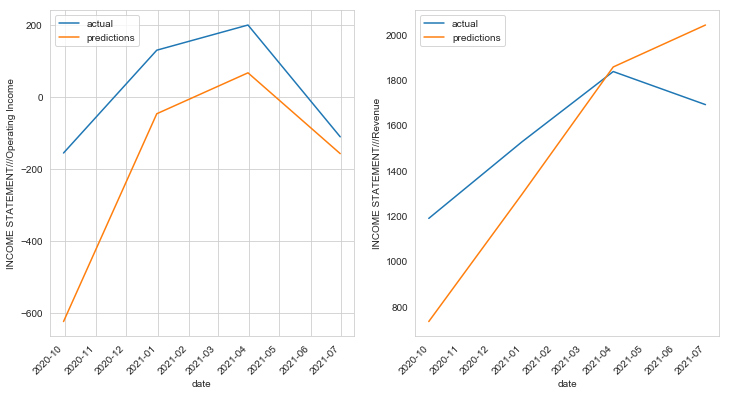

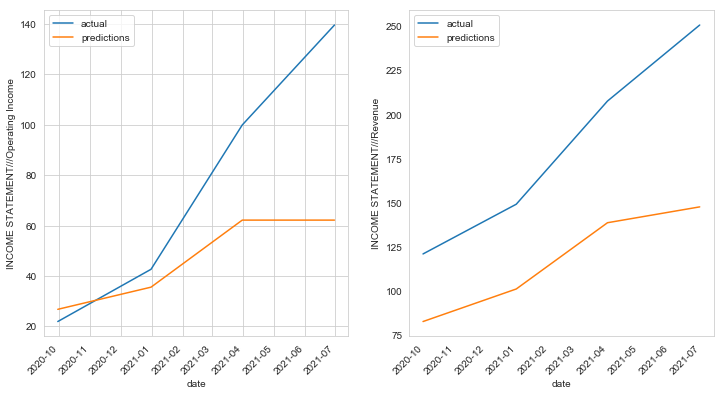

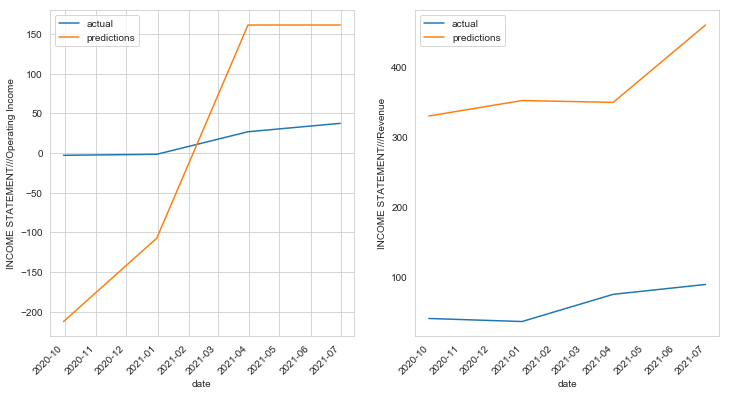

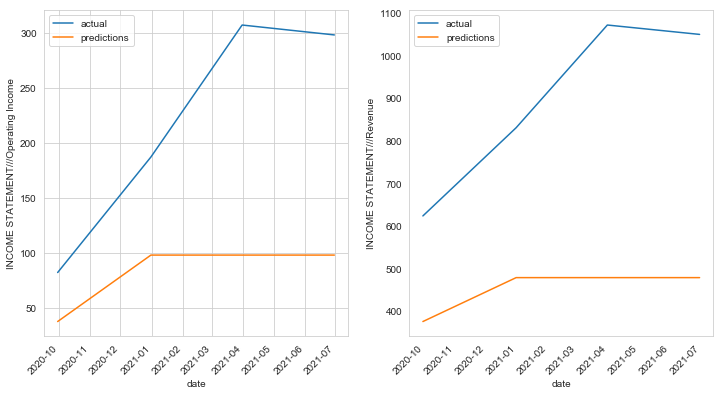

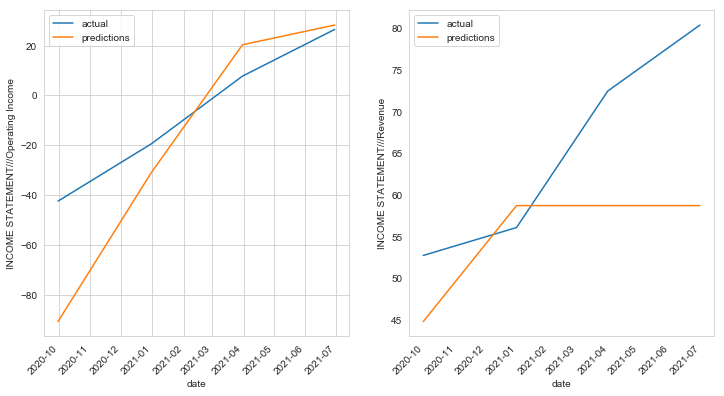

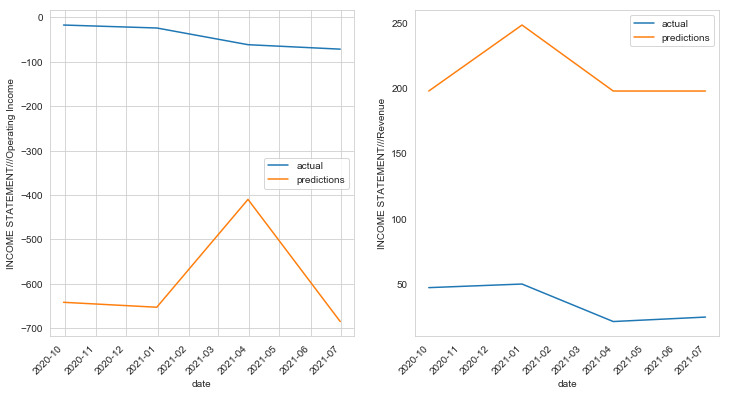

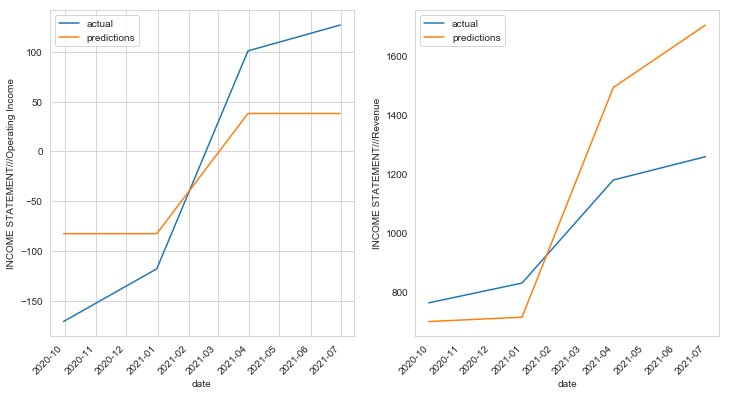

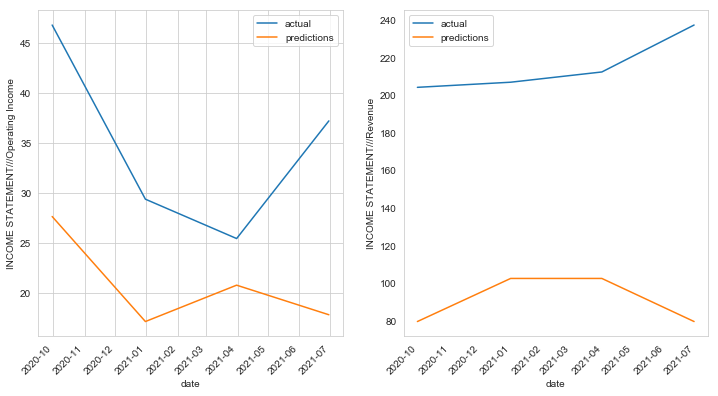

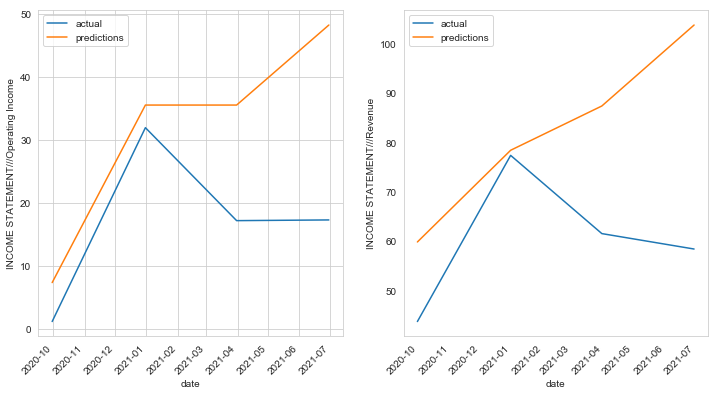

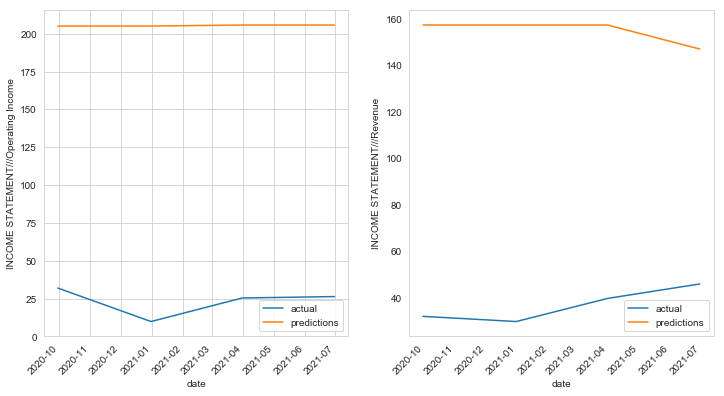

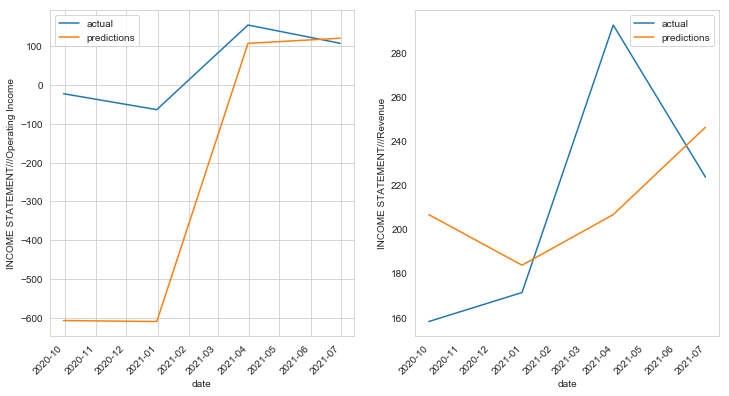

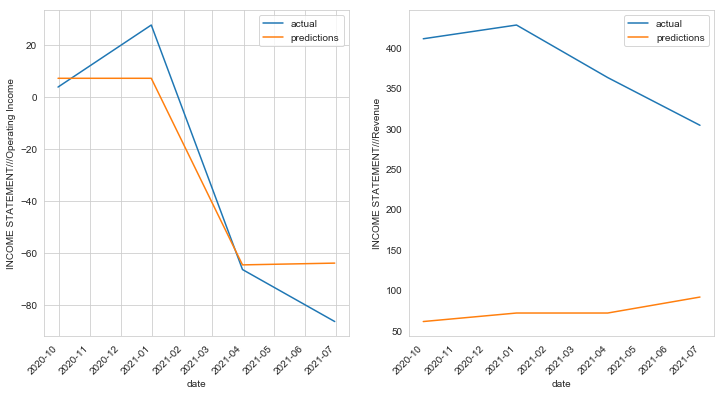

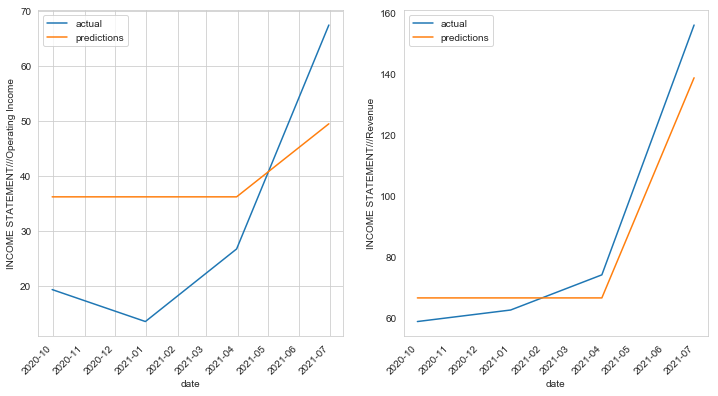

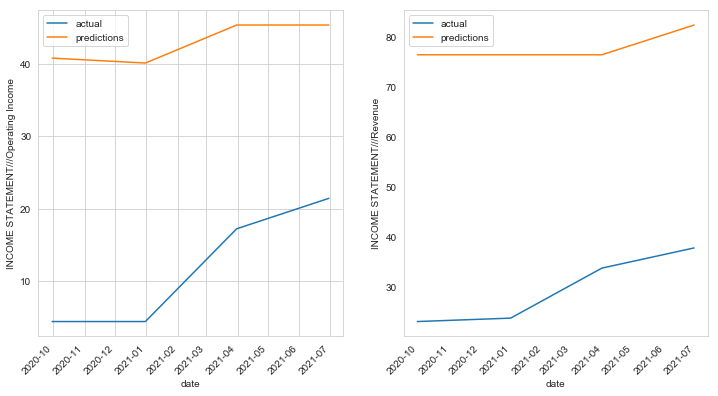

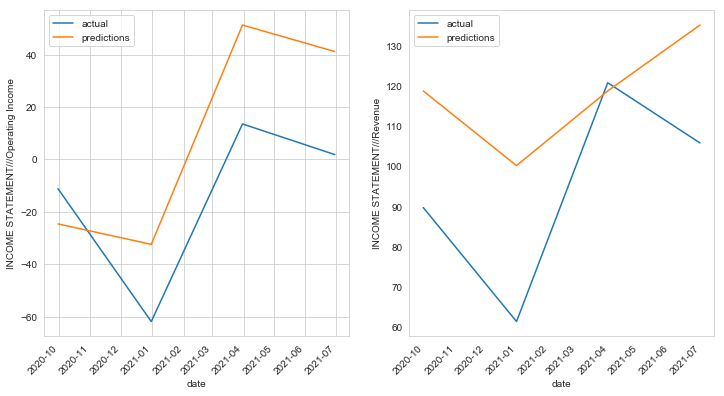

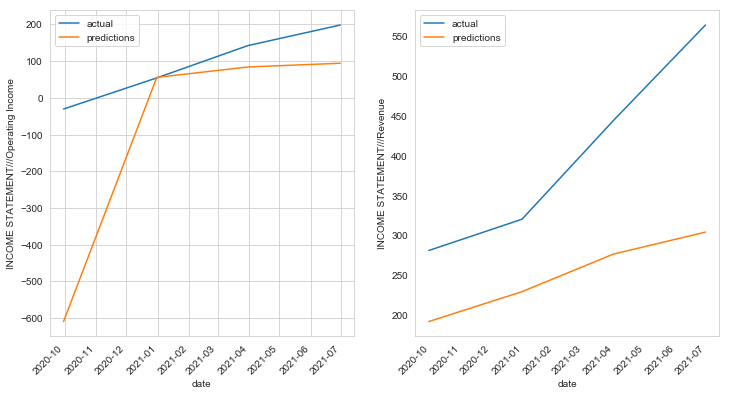

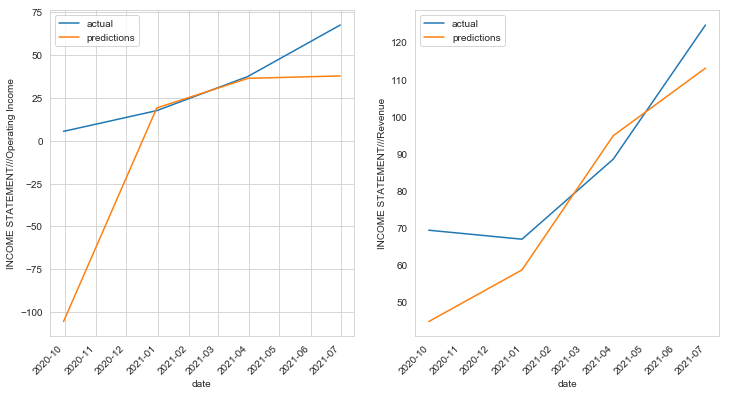

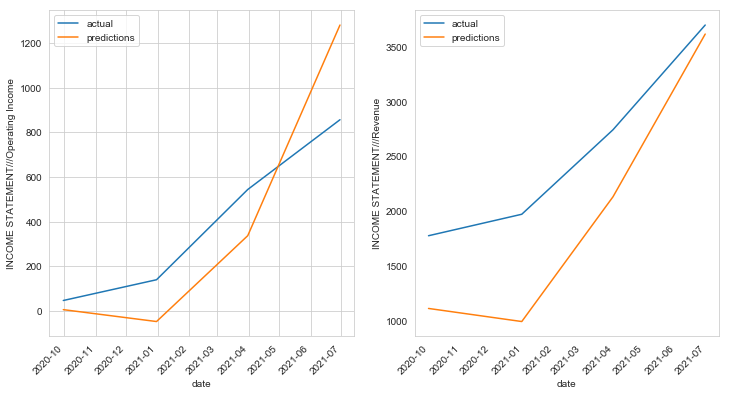

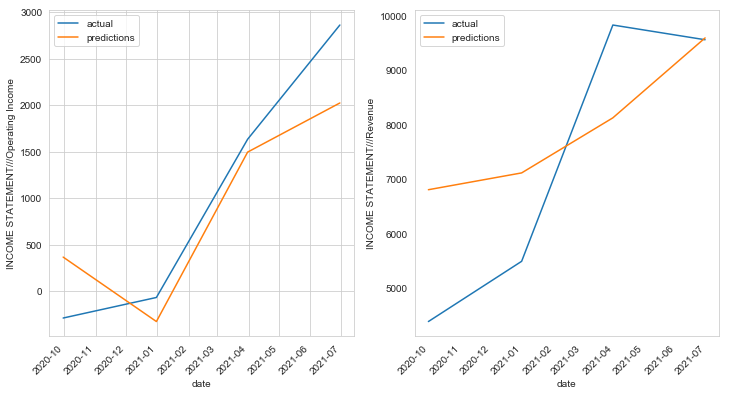

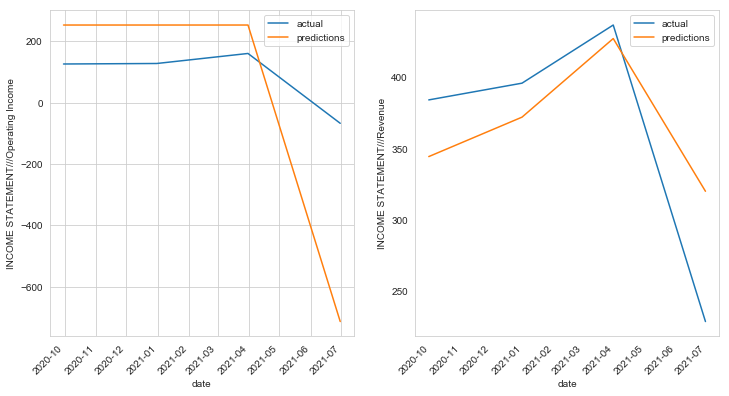

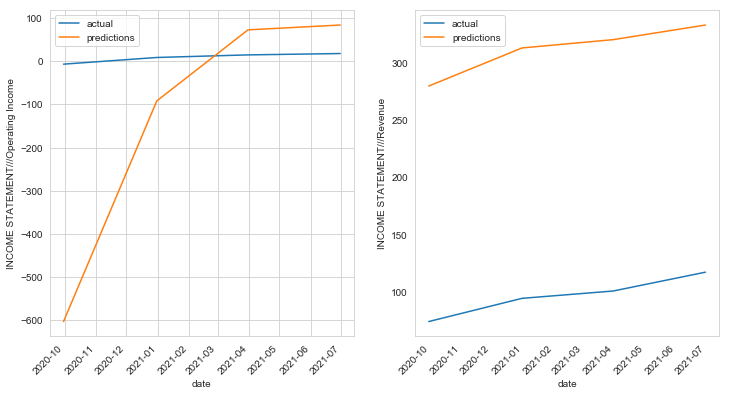

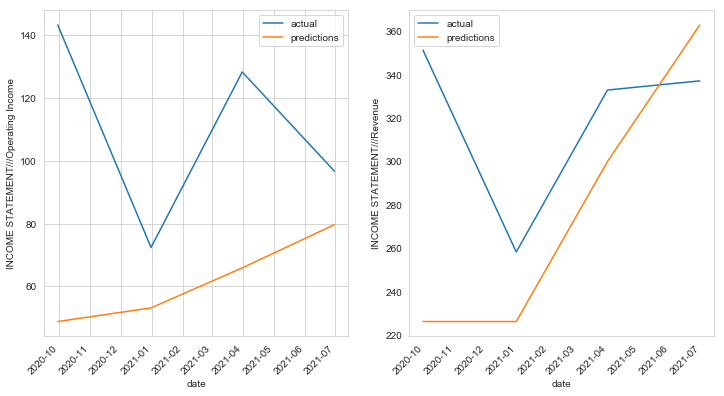

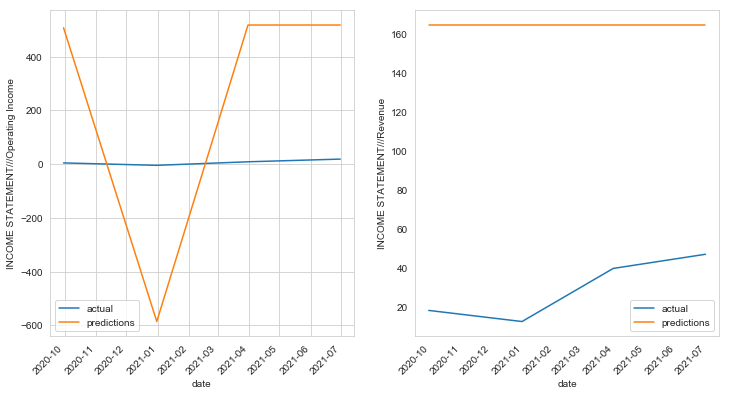

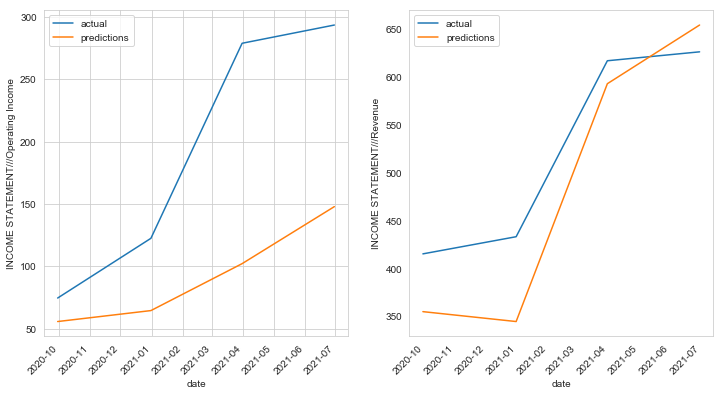

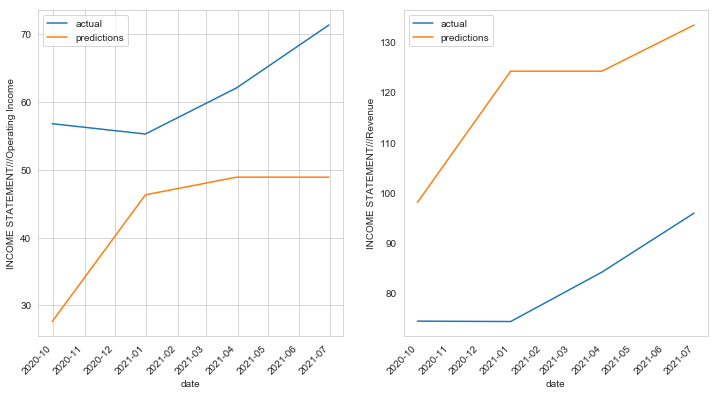

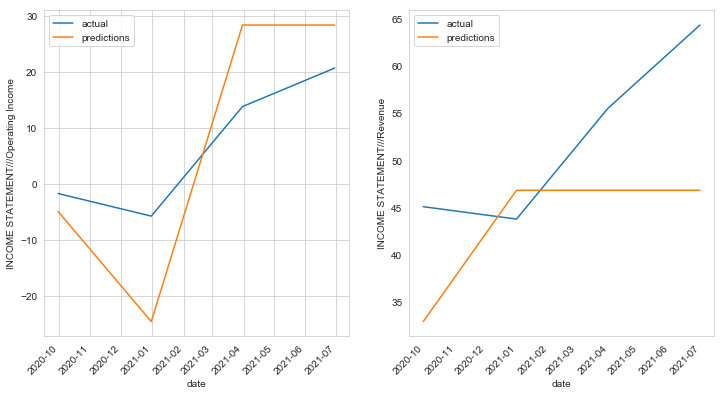

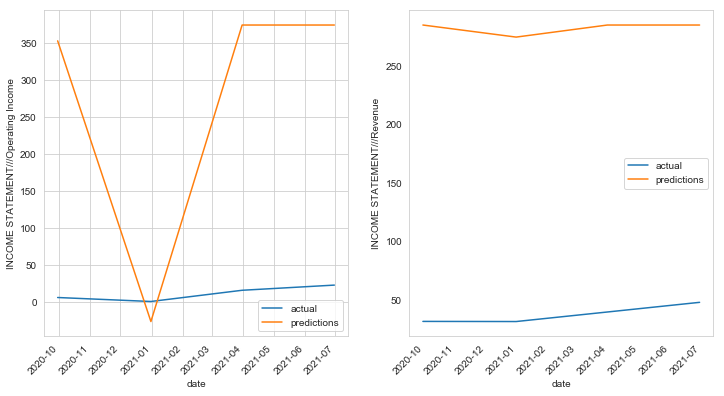

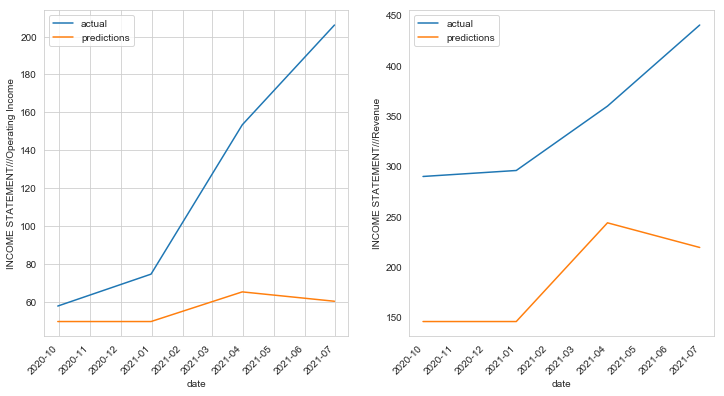

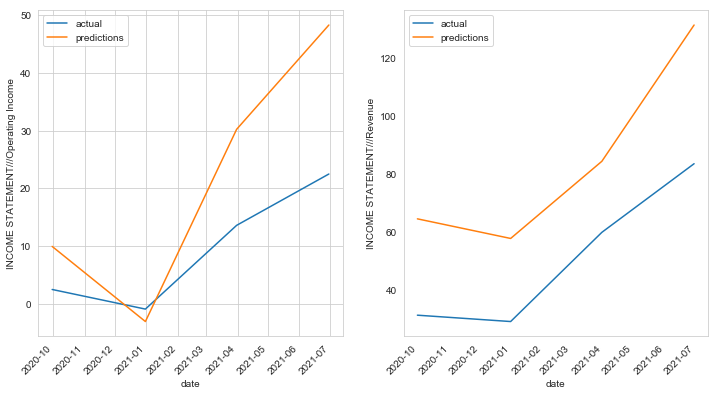

In [70]:
for comp in y_test_.loc[:,'company'].unique():
    fig, ax = plt.subplots(1,2)
    test_data = y_test_[y_test_['company']==comp]
    dates = test_data.index
    pred_data = xgb_preds[xgb_preds['company']==comp]
    sns.lineplot(x=dates, y=test_data[target[0]], label='actual', ax=ax[0])
    sns.lineplot(x=dates, y=pred_data[target[0]], label='predictions', ax=ax[0])
    sns.lineplot(x=dates ,y=test_data[target[1]], label='actual', ax=ax[1])
    sns.lineplot(x=dates, y=pred_data[target[1]], label='predictions', ax=ax[1])
    plt.draw()
    ax[0].set_xticks(ax[0].get_xticks())
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')
    ax[1].set_xticks(ax[1].get_xticks())
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')
    plt.grid()
    plt.show()

We see that XGB succeeds to make a good predictions even without any parameters adjustment, that show its strength.

## Other models

## Prophet

I've decided not to use a prophet model because it's basically continuous-time model so, as it's said in their documentation, it could lead to strange results.

## Tslearn

Also I was thinking about the usage of this library, but as far as I understand it now, tslearn is mostly about time series clustering then about making some predictions.

## Final decision

By now, I've decided to use an XGBoost model as a good benchmark for this task.

# <a name=second></a> Feature engineering

In [72]:
# we delete company that does not appear in test set
X = data_train.loc[~data_train['company'].isin(['CRBO']), ~data_train.columns.isin(target)]
y = data_test.copy()
y.index = data_test['company']

In [73]:
extracted_features = extract_features(X, column_id='company', column_sort='date', impute_function=impute)

Feature Extraction: 100%|██████████| 30/30 [00:12<00:00,  2.31it/s]


In [74]:
features_filtered0 = select_features(extracted_features, y.loc[y['date']==y.iloc[0]['date']][target[0]])
features_filtered1 = select_features(extracted_features, y.loc[y['date']==y.iloc[0]['date']][target[1]])

In [75]:
# as y must have the same length as the number of companies and must be dataseries
for date in data_test['date'].unique():
    print(date)
    y0 = y.loc[y['date']==date,target[0]]
    y1 = y.loc[y['date']==date,target[1]]
    try:
        features_filtered0 = select_features(features_filtered0, y0)
    except:
        pass
    try:
        features_filtered1 = select_features(features_filtered1, y1)
    except:
        pass

2020-09-30T00:00:00.000000000
2020-12-31T00:00:00.000000000
2021-03-31T00:00:00.000000000
2021-06-30T00:00:00.000000000


In [76]:
features_filtered0.shape, features_filtered1.shape

((52, 0), (52, 1913))

For some reason, we have no useful features left in the first case, but the other 1913 features are definitely sufficient for us.

Let's select the most important features using SHAP values of default XGB.

In [84]:
X_xgb = features_filtered1
y_xgb = y.loc[y['date']==y.iloc[0]['date']][target].loc[features_filtered1.index]
Xd = xgb.DMatrix(X_xgb, y_xgb)
model = xgb.train({}, Xd, 1, custom_metric=smape, maximize=False)
print("Model error =", smape(y_xgb,model.predict(Xd)))

Model error = 128.28228823771576


In [85]:
pred = model.predict(Xd, output_margin=True)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xd)

In [86]:
selected_features = []
for i in range(len(shap_values)):
    rf_resultX = pd.DataFrame(shap_values[i], columns = features_filtered1.columns)

    vals = np.abs(rf_resultX.values).mean(0)

    shap_importance = pd.DataFrame(list(zip(features_filtered1.columns, vals)),
                                      columns=['col_name','feature_importance_vals'])
    shap_importance.sort_values(by=['feature_importance_vals'],
                                   ascending=False, inplace=True)
    selected_features += shap_importance[shap_importance['feature_importance_vals']!=0]['col_name'].values.tolist()
selected_features = list(set(selected_features))

In [87]:
features_filtered1[selected_features].shape

(52, 19)

Finally, we add these features to our model.

In [88]:
X_train.loc[:,selected_features] = np.nan
X_test.loc[:,selected_features] = np.nan
for sel in selected_features:
    for comp in X_train['company'].unique():
        if comp in features_filtered1.index:
            X_train.loc[X_train['company']==comp,sel] = features_filtered1.loc[comp,sel]
            X_test.loc[X_test['company']==comp,sel] = features_filtered1.loc[comp,sel]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [89]:
X_train

company  BALANCE SHEET///Accounts Receivable  \
date                                                      
2011-12-31    AMPY                               27.454   
2012-03-31    AMPY                               21.830   
2012-06-30    AMPY                               19.567   
2012-09-30    AMPY                               23.307   
2012-12-31    AMPY                               39.484   
...            ...                                  ...   
2019-06-30     XOG                              121.660   
2019-09-30     XOG                              124.845   
2019-12-31     XOG                              137.112   
2020-03-31     XOG                               88.728   
2020-06-30     XOG                               96.874   

            BALANCE SHEET///Common Stock  \
date                                       
2011-12-31                         0.000   
2012-03-31                         0.000   
2012-06-30                         0.665   
2012-09-30                         0.665   
2012-12-31                         0.666   
...                                  ...   
2019-06-30                         1.384   
2019-09-30                         1.336   
2019-12-31                         1.336   
2020-03-31                         1.336   
2020-06-30                         1.336   

            BALANCE SHEET///Derivative & Hedging Assets  \
date                                                      
2011-12-31                                        4.957   
2012-03-31                                        0.517   
2012-06-30                                       12.038   
2012-09-30                                        0.987   
2012-12-31                                        5.695   
...                                                 ...   
2019-06-30                                       11.959   
2019-09-30                                       66.480   
2019-12-31                                       17.554   
2020-03-31                                      164.330   
2020-06-30                                       55.667   

            BALANCE SHEET///Line of Credit Used  \
date                                              
2011-12-31                                234.8   
2012-03-31                                234.8   
2012-06-30                                151.7   
2012-09-30                                250.0   
2012-12-31                                344.0   
...                                         ...   
2019-06-30                                480.0   
2019-09-30                                550.0   
2019-12-31                                470.0   
2020-03-31                                470.0   
2020-06-30                                600.5   

            BALANCE SHEET///Misc LT Assets  \
date                                         
2011-12-31                           1.879   
2012-03-31                           1.663   
2012-06-30                           3.660   
2012-09-30                          13.454   
2012-12-31                          25.413   
...                                    ...   
2019-06-30                          33.962   
2019-09-30                          45.876   
2019-12-31                          53.575   
2020-03-31                          30.600   
2020-06-30                          15.692   

            BALANCE SHEET///Other Accrued Liabilities  \
date                                                    
2011-12-31                                   0.000000   
2012-03-31                                  50.477000   
2012-06-30                                  62.985000   
2012-09-30                                  64.507000   
2012-12-31                                  98.649000   
...                                               ...   
2019-06-30                                 270.177984   
2019-09-30                                 206.956992   
2019-12-31                                 173.476000   
2020-03-31  

In [90]:
scalerX = StandardScaler().fit(X_train.loc[:,~X_train.columns.isin(['company'])])
train_for_scale = X_train.loc[:,~X_train.columns.isin(['company'])]
test_for_scale = X_test.loc[:,~X_test.columns.isin(['company'])]
X_train_scaled = pd.DataFrame(scalerX.transform(train_for_scale), index=train_for_scale.index, columns=train_for_scale.columns)
X_test_scaled = pd.DataFrame(scalerX.transform(test_for_scale), index=test_for_scale.index, columns=test_for_scale.columns)
X_train_scaled = pd.concat([X_train_scaled, X_train['company']], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test['company']], axis=1)

In [91]:
X_train_scaled.shape, X_test_scaled.shape

((1816, 53), (208, 53))

In [93]:
Xy_train_d = xgb.DMatrix(X_train_scaled, y_train, enable_categorical=True)
X_test_d = xgb.DMatrix(X_test_scaled, enable_categorical=True)
booster = xgb.train({"tree_method": "hist", "max_cat_to_onehot": 5}, Xy_train_d,
                    custom_metric=smape, maximize=False)

In [95]:
preds = booster.predict(X_test_d)
smape(y_test.values, preds)

23.66187839669207

Well, we've slightly improved our performace!

In [96]:
X_train.to_excel('data/X_train_feat_eng.xlsx')
y_train.to_excel('data/y_train_feat_eng.xlsx')
X_test.to_excel('data/X_test_feat_eng.xlsx')
y_test.to_excel('data/y_test_feat_eng.xlsx')

# <a name=third> </a>Hyperparameters

In [6]:
X_train = pd.read_excel('data/X_train_feat_eng.xlsx', index_col=0)
y_train = pd.read_excel('data/y_train_feat_eng.xlsx', index_col=0)
X_test = pd.read_excel('data/X_test_feat_eng.xlsx', index_col=0)
y_test = pd.read_excel('data/y_test_feat_eng.xlsx', index_col=0)

In [7]:
X_train['company'] = X_train['company'].astype('category')
X_test['company'] = X_test['company'].astype('category')

In [8]:
X_train

company  BALANCE SHEET///Accounts Receivable  \
date                                                      
2011-12-31    AMPY                               27.454   
2012-03-31    AMPY                               21.830   
2012-06-30    AMPY                               19.567   
2012-09-30    AMPY                               23.307   
2012-12-31    AMPY                               39.484   
...            ...                                  ...   
2019-06-30     XOG                              121.660   
2019-09-30     XOG                              124.845   
2019-12-31     XOG                              137.112   
2020-03-31     XOG                               88.728   
2020-06-30     XOG                               96.874   

            BALANCE SHEET///Common Stock  \
date                                       
2011-12-31                         0.000   
2012-03-31                         0.000   
2012-06-30                         0.665   
2012-09-30                         0.665   
2012-12-31                         0.666   
...                                  ...   
2019-06-30                         1.384   
2019-09-30                         1.336   
2019-12-31                         1.336   
2020-03-31                         1.336   
2020-06-30                         1.336   

            BALANCE SHEET///Derivative & Hedging Assets  \
date                                                      
2011-12-31                                        4.957   
2012-03-31                                        0.517   
2012-06-30                                       12.038   
2012-09-30                                        0.987   
2012-12-31                                        5.695   
...                                                 ...   
2019-06-30                                       11.959   
2019-09-30                                       66.480   
2019-12-31                                       17.554   
2020-03-31                                      164.330   
2020-06-30                                       55.667   

            BALANCE SHEET///Line of Credit Used  \
date                                              
2011-12-31                                234.8   
2012-03-31                                234.8   
2012-06-30                                151.7   
2012-09-30                                250.0   
2012-12-31                                344.0   
...                                         ...   
2019-06-30                                480.0   
2019-09-30                                550.0   
2019-12-31                                470.0   
2020-03-31                                470.0   
2020-06-30                                600.5   

            BALANCE SHEET///Misc LT Assets  \
date                                         
2011-12-31                           1.879   
2012-03-31                           1.663   
2012-06-30                           3.660   
2012-09-30                          13.454   
2012-12-31                          25.413   
...                                    ...   
2019-06-30                          33.962   
2019-09-30                          45.876   
2019-12-31                          53.575   
2020-03-31                          30.600   
2020-06-30                          15.692   

            BALANCE SHEET///Other Accrued Liabilities  \
date                                                    
2011-12-31                                   0.000000   
2012-03-31                                  50.477000   
2012-06-30                                  62.985000   
2012-09-30                                  64.507000   
2012-12-31                                  98.649000   
...                                               ...   
2019-06-30                                 270.177984   
2019-09-30                                 206.956992   
2019-12-31                                 173.476000   
2020-03-31  

In [11]:
scalerX = StandardScaler().fit(X_train.loc[:,~X_train.columns.isin(['company'])])
train_for_scale = X_train.loc[:,~X_train.columns.isin(['company'])]
test_for_scale = X_test.loc[:,~X_test.columns.isin(['company'])]
X_train_scaled = pd.DataFrame(scalerX.transform(train_for_scale), index=train_for_scale.index, columns=train_for_scale.columns)
X_test_scaled = pd.DataFrame(scalerX.transform(test_for_scale), index=test_for_scale.index, columns=test_for_scale.columns)
X_train_scaled = pd.concat([X_train_scaled, X_train['company']], axis=1)
X_test_scaled = pd.concat([X_test_scaled, X_test['company']], axis=1)

In [12]:
X_train_scaled.shape, X_test_scaled.shape

((1816, 53), (208, 53))

As it's more convenient to do grid search with sklearn-api boosting, let's switch to it

In [17]:
xgbr = xgb.XGBRegressor(tree_method='hist', enable_categorical=True, seed=42)
xgbr.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [18]:
smape(y_test, preds)

22.660541967283194

For some reason, it performs even more better then the previous boosting, let's do a grid search:

In [32]:
parameters_grid = {
    'n_estimators' : [100, 200, 300],
    #'subsample' : [0.7, 0.8, 0.9, 1.0],
    'max_depth' : [5, 6, 7, 8, 9],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
    'gamma' : [0, 0.001, 0.01, 0.05],
    'reg_alpha' : [0, 0.001, 0.01],
    'reg_lambda' : [0.5, 1, 2]
}

In [33]:
%%time
xgbr = xgb.XGBRegressor(seed = 42, tree_method='hist', enable_categorical=True, eval_metric=smape)
CV = RandomizedSearchCV(estimator=xgbr, 
                         param_distributions=parameters_grid,
                         cv=TimeSeriesSplit(n_splits=4),
                         n_iter=1000,
                         scoring=make_scorer(smape, greater_is_better=False),
                         verbose=1)
CV.fit(X_train_scaled, y_train)
print('Best parameters:', CV.best_params_)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed: 73.0min finished


Best parameters: {'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.4, 'gamma': 0.05}
CPU times: user 13h 37min 17s, sys: 15min 44s, total: 13h 53min 1s
Wall time: 1h 13min 1s


In [26]:
CV.cv_results_

{'mean_fit_time': array([0.21322966, 0.40493649, 0.62924355, 0.68121618, 1.1714375 ,
        0.22666752, 0.62277871, 0.22322601, 1.4512881 , 1.6975255 ,
        0.4495182 , 0.54503208, 0.55018127, 1.09043944, 0.46318132,
        0.42048103, 1.26233447, 1.46632665, 0.69049364, 0.70916402,
        1.16164023, 0.82103139, 1.15603387, 0.96252757, 0.98459274,
        0.22008133, 0.34524977, 1.55379695, 0.9832778 , 0.91998917,
        1.3158145 , 0.41506308, 0.6742245 , 0.40523672, 0.69760871,
        1.54994273, 0.9472633 , 0.37878841, 0.42340106, 1.13090056,
        0.69382131, 1.15003181, 0.75748223, 0.54954177, 1.16900802,
        0.91769022, 1.13361704, 1.37259817, 0.38290268, 0.21940899,
        0.80220717, 0.87977868, 1.43417305, 1.76799494, 0.89665133,
        0.23286384, 0.35386848, 1.89794582, 0.32081646, 0.57400954,
        1.04884648, 0.77831018, 1.81840152, 0.49037397, 0.81687665,
        1.44085771, 0.21430302, 1.11967355, 0.55177444, 0.74952275,
        0.54651952, 0.75630766,

In [22]:
final_params = {'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.4, 'gamma': 0.05}
final_params.update({'tree_method':'hist', 'enable_categorical': True, 'seed': 42, 'eval_metric' : smape})
xgbr = xgb.XGBRegressor(**final_params)
xgbr.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=True,
             eval_metric=<function smape at 0x7faeecb0b320>, gamma=0.05,
             gpu_id=-1, grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.4, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=5, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=42, reg_alpha=0, reg_lambda=2, ...)

In [23]:
preds = xgbr.predict(X_test_scaled)
smape(y_test, preds)

35.57873232062041

Test errors have slightly decreased, but this result is due to the CV-evaluation method. We should rely rather on it than on a test scores.

### Back to original API

In [30]:
final_params.pop('n_estimators')

100

In [31]:
final_params

{'reg_lambda': 2,
 'reg_alpha': 0,
 'max_depth': 5,
 'learning_rate': 0.4,
 'gamma': 0.05,
 'tree_method': 'hist',
 'enable_categorical': True,
 'seed': 42}

In [35]:
Xy_train_d = xgb.DMatrix(X_train_scaled, y_train, enable_categorical=True)
X_test_d = xgb.DMatrix(X_test_scaled, enable_categorical=True)
booster = xgb.train(final_params, Xy_train_d, num_boost_round=100,
                    custom_metric=smape, maximize=False)

In [39]:
X_test_d = xgb.DMatrix(X_test_scaled, enable_categorical=True)
preds = booster.predict(X_test_d)
smape(y_test, preds)

35.57873232062041

### SHAP

Let's compute SHAP values

In [48]:
try:
    explainer = shap.TreeExplainer(booster)
    shap_values = explainer.shap_values(X_test_d)
except Exception:
    print('Doesn\'t work!')

Doesn't work!


Unfortunately, SHAP doesn't support pandas categorical variable, so let's encode company using standard sklearn functionality.